# Two-Stream Convolutional Network for Action Recognition - The Grand Finale!

Alright, I've been on a bit of a journey with the **HMDB51 dataset**, tackling the tricky world of action recognition. I've built a few models along the way – **3D CNN v1.0**, **3D CNN v2.0**, and even had a crack at a **Fine-tuned ResNet-50**. But this, this is the last chapter: the **Two-Stream Convolutional Neural Network** which to be honest I did not have any idea about it and I saw on [On the Integration of Optical Flow and Action Recognition (GCPR 2018)](https://www.cvlibs.net/publications/Sevilla-Lara2018GCPR.pdf) that someone mentioned it as they were trying to consider the motion in their dataset, so I thought that would be a good idea to give it a go.

I've put this model together to really push it a bit higher (finger crossed), combining the best of both worlds in video analysis:

* **Spatial Stream (RGB Frames) :** This is where I focused on what things *look* like. My model learns to spot actions purely from the visual appearance in individual video frames. Think of it as teaching the model to identify "a person brushing hair" just by seeing the hairbrush and the person's pose.
* **Temporal Stream (Optical Flow) :** This stream is all about the *motion*. I fed it dense optical flow fields to capture how pixels are moving across frames. This is absolutely crucial for understanding the dynamics of an action – you know, the "brushing" part of "brushing hair."

The whole point of this two-stream setup is that these two types of information are **complementary**. What the RGB stream can't quite grasp from static images, the flow stream picks up from the movement, and vice-versa, each bringing their unique skills to the table!


### Here's What I've Done:

| Stage                | What I Did                                                                        | Why                                                     |
| :------------------- | :-------------------------------------------------------------------------------- | :---------------------------------------------------------------- |
| **Data Prep** | Loaded HMDB51, got all my RGB frames and pre-computed optical flow ready.         | Ensuring the models have crystal-clear data to learn from and keep my GPU intact for later.        |
| **Model Architecture** | Hooked up **pre-trained ResNet-18s** for both streams, adapting them for video.     | Leveraging powerful image knowledge and customising for flow.     |
| **Training & Val.** | Independently trained each stream, throwing in **dropout** and **early stopping**. | Preventing overfitting and making sure the models learn robustly. |
| **Late Fusion** | averaged the **softmax probabilities** from both streams for a final guess.| Combining their strengths for a supercharged prediction!          |
| **Evaluation** | Checked performance on a test set, giving you **Top-1 and Top-5 accuracies**.    | The real test! Seeing how it performs on completely unseen data.  |

---


### Step 1: Mount Google Drive and Set Up Paths

first things first, gotta get our workspace sorted!

In [ ]:
from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

base_drive_path = '/content/drive/MyDrive/HMDB51'

if not os.path.exists(base_drive_path):
    print(f"WARNING: The path {base_drive_path} does not exist.")
else:
    print(f"Base data path on Drive found: {base_drive_path}")


local_data_path = '/content/data'
if not os.path.exists(local_data_path):
    os.makedirs(local_data_path)
    print(f"Created local data directory: {local_data_path}")
else:
    print(f"Local data directory already exists: {local_data_path}")



### Step 2: Unzip the Dataset

Right then, with Google Drive mounted, my next job was to **get the actual HMDB51 data unzipped and ready**. I had the video frames and the test/train splits tucked away in zipped files on my Drive, so this chunk was all about extracting them. I whipped up a little function to handle the unzipping gracefully, making sure to **check if the files existed** and if the **extraction was successful**. It's a crucial step to get all those images and annotation files in place for the models to feast on!

In [ ]:
import zipfile
import os

# Define paths to the zipped files on Google Drive
frames_zip_path = os.path.join(base_drive_path, 'frames.zip')
splits_zip_path = os.path.join(base_drive_path, 'test_train_splits.zip')

print(f"Attempting to extract {frames_zip_path} and {splits_zip_path} to {local_data_path}")

# Function to extract a zip file
def extract_zip(zip_path, extract_to_path):
    if not os.path.exists(zip_path):
        print(f"Error: Zip file not found at {zip_path}.")
        return False

    print(f"Extracting {zip_path}...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)
        print(f"Successfully extracted {zip_path} to {extract_to_path}")
        return True
    except Exception as e:
        print(f"Error extracting {zip_path}: {e}")
        return False

# Extract frames.zip
if extract_zip(frames_zip_path, local_data_path):
    print("Frames extraction complete.")
else:
    print("Frames extraction failed.")

# Extract test_train_splits.zip
if extract_zip(splits_zip_path, local_data_path):
    print("Splits extraction complete.")
else:
    print("Splits extraction failed.")



# Verify extracted paths
expected_frames_dir = os.path.join(local_data_path, 'frames')
expected_splits_dir = os.path.join(local_data_path, 'test_train_splits')

if os.path.exists(expected_frames_dir):
    print(f"Verified: Frames directory exists at {expected_frames_dir}")
else:
    print(f"WARNING: Frames directory NOT found at {expected_frames_dir}")

if os.path.exists(expected_splits_dir):
    print(f"Verified: Splits directory exists at {expected_splits_dir}")
else:
    print(f"WARNING: Splits directory NOT found at {expected_splits_dir}")




Attempting to extract /content/drive/MyDrive/HMDB51/frames.zip and /content/drive/MyDrive/HMDB51/test_train_splits.zip to /content/data
Extracting /content/drive/MyDrive/HMDB51/frames.zip...
Successfully extracted /content/drive/MyDrive/HMDB51/frames.zip to /content/data
Frames extraction complete.
Extracting /content/drive/MyDrive/HMDB51/test_train_splits.zip...
Successfully extracted /content/drive/MyDrive/HMDB51/test_train_splits.zip to /content/data
Splits extraction complete.
Verified: Frames directory exists at /content/data/frames
Verified: Splits directory exists at /content/data/test_train_splits


### Step 3: Preparing the Dataset: Metadata, Splits & Sanity Checks 

Right, with the raw data unzipped, the next big task was to **make sense of it all and get it organised**. In this chunk, I dove into the HMDB51 dataset's structure. Here's what I got up to:

* **Parsing Annotation Files:** I went through the `test_train_splits` files. HMDB51 is a bit particular, offering three predefined splits, so I focused on **Split 1** for consistency with my previous models. This allowed me to correctly identify which videos belonged to the training set and which to the testing set and which should be ignored.
* **Mapping Paths:** For every video, I made sure to construct the **exact file path** to its corresponding frames and optical flow data. This was a crucial sanity check to ensure that the data I was looking for actually existed on disk – no point in training if the files aren't there! If a video's folder was missing, I'd give myself a little warning, but I'd keep pushing through which that actually happened and if you already saw the extraction notebook for flows you would see that 7 videos were ignored back then cause they they didn't have enough flows to be extracted.
* **Building the DataFrame:** All this gathered information – video names, their action class, which split they belonged to, and their file paths – I neatly compiled it into a **pandas DataFrame**. This DataFrame became my single source of truth for accessing video information throughout the project.
* **Label Encoding:** Finally, I converted the human-readable class names (like "brush\_hair" or "fall\_floor") into **numerical labels** using a `LabelEncoder`. This is essential because neural networks, prefer numbers over text!

This whole process was about getting the data squeaky clean and perfectly structured, ready for the PyTorch `Dataset` and `DataLoader` magic that follows.

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


local_data_path = '/content/data'
splits_dir = os.path.join(local_data_path, 'test_train_splits')
frames_base_dir = os.path.join(local_data_path, 'frames')

all_videos_info = []

# List all class directories
class_dirs = [d for d in os.listdir(frames_base_dir) if os.path.isdir(os.path.join(frames_base_dir, d))]
class_dirs.sort()

print(f"Found {len(class_dirs)} classes: {class_dirs}")

# Iterate through each split file for split 1 as we did for previous models
print("Parsing split files for Split 1...")
for class_name in class_dirs:
    split_file_name = f"{class_name}_test_split1.txt"
    split_file_path = os.path.join(splits_dir, split_file_name)

    if not os.path.exists(split_file_path):
        print(f"WARNING: Split file not found for {class_name}: {split_file_path}. Skipping.")
        continue

    with open(split_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            if len(parts) == 2:
                video_filename_with_ext = parts[0] # e.g., 'video_name.avi'
                video_name = video_filename_with_ext.split('.')[0] # e.g., 'video_name'
                split_status = int(parts[1]) # 1 for train, 2 for test, 0 for ignore

                # Construct the full path to the video's frames/flows folder
                video_data_path = os.path.join(frames_base_dir, class_name, video_name)

                # Check if the video's actual data folder exists
                if os.path.exists(video_data_path):
                    all_videos_info.append({
                        'video_name': video_name,
                        'class_name': class_name,
                        'split_status': split_status,
                        'video_path': video_data_path # Path to the specific video's frames/flows
                    })
                else:
                    print(f"WARNING: Video data folder not found for {video_name} in class {class_name} at {video_data_path}. Skipping.")

# Create a DataFrame
df = pd.DataFrame(all_videos_info)

# Filter for split 1 (1 and 2, ignoring 0)
df_split1 = df[df['split_status'] != 0].copy()

print(f"\nTotal videos parsed for Split 1 (excluding ignored): {len(df_split1)}")
print(f"Distribution of split status:\n{df_split1['split_status'].value_counts()}")

# Map split_status to 'train' and 'test' strings
df_split1['subset'] = df_split1['split_status'].map({1: 'train', 2: 'test'})



Found 51 classes: ['brush_hair', 'cartwheel', 'catch', 'chew', 'clap', 'climb', 'climb_stairs', 'dive', 'draw_sword', 'dribble', 'drink', 'eat', 'fall_floor', 'fencing', 'flic_flac', 'golf', 'handstand', 'hit', 'hug', 'jump', 'kick', 'kick_ball', 'kiss', 'laugh', 'pick', 'pour', 'pullup', 'punch', 'push', 'pushup', 'ride_bike', 'ride_horse', 'run', 'shake_hands', 'shoot_ball', 'shoot_bow', 'shoot_gun', 'sit', 'situp', 'smile', 'smoke', 'somersault', 'stand', 'swing_baseball', 'sword', 'sword_exercise', 'talk', 'throw', 'turn', 'walk', 'wave']
Parsing split files for Split 1...

Total videos parsed for Split 1 (excluding ignored): 5086
Distribution of split status:
split_status
1    3563
2    1523
Name: count, dtype: int64


---
### Step 4: Data Splits & Label Encoding

with the main data parsing done, this chunk was all about the crucial step of **finalising my dataset splits and getting the labels encoded**. Here's what I did:

* **Label Encoding Magic:** First up, I grabbed my `class_name` column and put it through a `LabelEncoder`. This transforms those readable action names (like 'swing_baseball' or 'fall_floor') into crisp, clean **numerical labels**. This is essential for PyTorch and my models, as they speak in numbers, not words! I also made sure to capture the total `num_classes`, which is a must for the model's final output layer.
* **Train, Validate, Test:** Next, I **split my data**. I separated the main `df_split1` into dedicated `train_df` and `test_df` based on the pre-defined HMDB51 splits. Then, to get a solid validation set (essential for tracking how well my model's really learning without peeking at the test data), I took a **15% slice from the `train_df`** and designated it as `val_videos`. I made sure this split was **stratified** (`stratify=train_df['label']`) – this is a clever trick to ensure that each of my 51 classes is proportionally represented in both the training and validation sets, preventing any nasty biases.
* **Global Access:** Finally, I saved all these vital DataFrames (`train_videos`, `val_videos`, `test_df`), my `label_encoder`, and the `num_classes` into **global variables**. This just makes them super easy to access in all the subsequent steps, like when I'm building my DataLoaders or defining my models.



In [4]:
# --- Label Encoding ---
print("\nPerforming Label Encoding for classes...")
label_encoder = LabelEncoder()
df_split1['label'] = label_encoder.fit_transform(df_split1['class_name'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print("Class mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {i}")

# --- Create Train, Validation, Test Sets ---
print("\nCreating Train, Validation, and Test sets...")
train_df = df_split1[df_split1['subset'] == 'train']
test_df = df_split1[df_split1['subset'] == 'test']


train_videos, val_videos = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df['label']) # 15% for validation

print(f"\nTrain videos: {len(train_videos)}")
print(f"Validation videos: {len(val_videos)}")
print(f"Test videos: {len(test_df)}")

# Store these dataframes and label_encoder for the next steps
# Using global variables for simplicity in Colab chunks
global_train_df = train_videos
global_val_df = val_videos
global_test_df = test_df
global_label_encoder = label_encoder
global_num_classes = num_classes
global_class_dirs = class_dirs # Store class names for later checks

print("Sample of training data head:")
print(global_train_df.head())


Performing Label Encoding for classes...
Number of classes: 51
Class mapping:
  brush_hair: 0
  cartwheel: 1
  catch: 2
  chew: 3
  clap: 4
  climb: 5
  climb_stairs: 6
  dive: 7
  draw_sword: 8
  dribble: 9
  drink: 10
  eat: 11
  fall_floor: 12
  fencing: 13
  flic_flac: 14
  golf: 15
  handstand: 16
  hit: 17
  hug: 18
  jump: 19
  kick: 20
  kick_ball: 21
  kiss: 22
  laugh: 23
  pick: 24
  pour: 25
  pullup: 26
  punch: 27
  push: 28
  pushup: 29
  ride_bike: 30
  ride_horse: 31
  run: 32
  shake_hands: 33
  shoot_ball: 34
  shoot_bow: 35
  shoot_gun: 36
  sit: 37
  situp: 38
  smile: 39
  smoke: 40
  somersault: 41
  stand: 42
  swing_baseball: 43
  sword: 44
  sword_exercise: 45
  talk: 46
  throw: 47
  turn: 48
  walk: 49
  wave: 50

Creating Train, Validation, and Test sets...

Train videos: 3028
Validation videos: 535
Test videos: 1523
Sample of training data head:
                                             video_name class_name  \
3821                Fellowship_7_run_f_cm

---
### Step 5: Defining Dataset Classes and Image Transformations

Alright, this is where I got down to of **how my models actually "see" the data**. It's all about setting up the custom `Dataset` classes for PyTorch and defining the **image transformations** that prepare my frames and optical flow for the neural networks. Here’s what I did in this chunk of code:

* **Configuration Constants:** First, I laid out some key numbers, like the `IMG_SIZE` (which I set to 224x224, standard for ResNet), how many RGB frames I'd `SAMPLE` (16 frames), and how many optical flow frames I'd `STACK` (a crucial 15 pairs, 15 x_flows / 15 y_flows, giving me 30 channels!).
* **RGB Stream Transformations:** For my spatial stream, I set up two sets of transformations:
    * **`rgb_train_transforms`**: For training, I applied some **data augmentation** techniques like `RandomResizedCrop` and `RandomHorizontalFlip`. These bits help my model see the same action from slightly different angles or scales, making it more robust and less prone to overfitting. Then, it's `ToTensor()` and `Normalize()` using those well-known **ImageNet statistics** – super important since my ResNet is pre-trained on ImageNet!
    * **`rgb_val_test_transforms`**: For validation and testing, I stuck to more deterministic transformations like `Resize` and `CenterCrop` to get consistent inputs, followed by `ToTensor()` and `Normalize()`.
* **Optical Flow Stream Transformations:** The temporal stream needed its own set of rules:
    * **`flow_train_transforms` & `flow_val_test_transforms`**: I kept the `RandomResizedCrop` and `RandomHorizontalFlip` for augmentation here too. However, crucially, I **omitted the `Normalize` step** using ImageNet stats. As I found out, optical flow data has wildly different value ranges and properties than standard RGB images, so applying ImageNet normalization can actually confuse the model rather than help it. `ToTensor()` still scales the pixel values to `[0,1]`, which is generally fine.



In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import random


# --- Configuration for Data Loading ---
IMG_SIZE = 224 # Standard input size for ResNet

NUM_RGB_FRAMES_TO_SAMPLE = 16

NUM_FLOW_FRAMES_TO_STACK = 15 # This will result in 15_x_flows + 15_y_flows = 30 channels


# --- Define Transformations ---
# ImageNet statistics for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transformations for RGB stream
rgb_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE), # Random crop and resize
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.ToTensor(),                   # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalize
])

rgb_val_test_transforms = transforms.Compose([
    transforms.Resize(256),                  # Resize smaller edge to 256
    transforms.CenterCrop(IMG_SIZE),         # Crop the center 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Transformations for Optical Flow stream
# Using a neutral normalization for now as flow values are different.
# ToTensor will scale to [0,1].
flow_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(), # This flips the image, not necessarily inverting flow_x values
    transforms.ToTensor(), # Converts to [0,1]
])

flow_val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(), # Converts to [0,1]
])






---
### Step 6: Crafting the RGB Dataset Class

The next logical step was to build the **custom PyTorch `Dataset` for my RGB stream**. This `HMDB51RGBDataset` is essentially the blueprint for how my training and validation loaders will fetch and prepare individual RGB frames. Here's a breakdown of what I build up:

* **`__init__(self, dataframe, transform=None)`:** The constructor simply takes my pre-prepared DataFrame (from Step 4) and the chosen transformations (from Step 5). Standard stuff!
* **`__len__(self)`:** This little helper just tells PyTorch how many video samples are in my dataset.
* **`__getitem__(self, idx)`:** This is the heart of the dataset! When PyTorch asks for an item at a specific `idx`:
    * I first grab all the relevant info for that video from my DataFrame, including its `video_path` and `label`.
    * Then, I head into that video's directory to find **all its RGB frame files**. I made sure to sort them numerically so I could keep track.
    * **Crucial Frame Sampling:** Originally, I was sampling multiple frames (`NUM_RGB_FRAMES_TO_SAMPLE`) for some averaging, but then I simplified it to just **randomly picking a single frame** from the video. This speeds things up and is often a good starting point for spatial stream models. I then load this chosen frame as a PIL Image.
    * Finally, I apply the `transform` (either training or validation/test ones, depending on how the dataset is instantiated) to the image.
    * The function then hands over the **processed RGB image tensor** and its corresponding **ground truth `label`** to the DataLoader.



In [6]:
# --- Custom Dataset Class for RGB Stream ---
class HMDB51RGBDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        video_info = self.dataframe.iloc[idx]
        video_path = video_info['video_path']
        label = video_info['label']

        frames_dir = video_path
        all_frames = sorted([f for f in os.listdir(frames_dir) if f.startswith('00') and f.endswith('.jpg')])

        if not all_frames:
            raise FileNotFoundError(f"No frames found in {frames_dir}")
        if len(all_frames) < NUM_RGB_FRAMES_TO_SAMPLE:
            raise ValueError(f"Not enough frames ({len(all_frames)}) in {frames_dir} to sample {NUM_RGB_FRAMES_TO_SAMPLE}")


        indices = np.linspace(0, len(all_frames) - 1, NUM_RGB_FRAMES_TO_SAMPLE).astype(int)

        sampled_images = []
        for i in indices:
            frame_filename = all_frames[i]
            img_path = os.path.join(frames_dir, frame_filename)
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            sampled_images.append(image)




        frame_idx = random.randint(0, len(all_frames) - 1)
        frame_filename = all_frames[frame_idx]
        img_path = os.path.join(frames_dir, frame_filename)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

---
### Step 7: Building the Optical Flow Dataset Class

the RGB side was sorted, but now it was time for the really interesting bit: creating the **custom PyTorch `Dataset` for my Optical Flow stream**. This `HMDB51FlowDataset` is critical because optical flow inputs are quite different from standard RGB images. Here's how I tackled it:

* **`__init__(self, dataframe, transform=None)` and `__len__(self)`:** These bits were pretty standard, mirroring the RGB dataset setup – taking my DataFrame and transformations, and telling PyTorch how many samples I had.
* **`__getitem__(self, idx)`: The Motion core if I may say!** This is where the real action happens for each video sample:
    * I pinpointed the `flows` sub-directory within the video's path, which is where my pre-computed optical flow images live.
    * I then gathered all the `flow_x_` (horizontal motion) and `flow_y_` (vertical motion) image files, making sure they were sorted.
    * **The Crucial Stack:** Instead of just one image, the optical flow model expects a *stack* of consecutive flow images to understand motion over time. For HMDB51, I decided to use a stack of **15 consecutive flow images for both X and Y directions**. This means for each video, I load 15 `flow_x` images and 15 `flow_y` images.
    * Each of these individual flow images (`flow_x` and `flow_y`) was opened as a **grayscale image** (`'L'`) – they essentially represent motion magnitude and direction, not colour.
    * I applied the specific **flow transformations** (from Step 5) to each individual flow image.
    * Finally, I `torch.cat` (concatenated) all these processed flow tensors together along the channel dimension. This created a single input tensor with **30 channels** (15 for X-motion, 15 for Y-motion), ready to be fed into my adapted ResNet.



In [ ]:
# --- Custom Dataset Class for Optical Flow Stream ---
class HMDB51FlowDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        video_info = self.dataframe.iloc[idx]
        video_path = video_info['video_path']
        label = video_info['label']

        flows_dir = os.path.join(video_path, 'flows')

        all_flow_x = sorted([f for f in os.listdir(flows_dir) if f.startswith('flow_x_') and f.endswith('.jpg')])
        all_flow_y = sorted([f for f in os.listdir(flows_dir) if f.startswith('flow_y_') and f.endswith('.jpg')])

        if not all_flow_x or not all_flow_y or len(all_flow_x) != 15 or len(all_flow_y) != 15:
            raise FileNotFoundError(f"Missing or incomplete flow files in {flows_dir}. Found X: {len(all_flow_x)}, Y: {len(all_flow_y)}")

        # We need to stack 15 consecutive flows for x and y.
        # This means the flow_stack will have 15*2 = 30 channels.
        # Since we have exactly 15 flow frames (0001 to 0015),
        # we can just use all of them.

        stacked_flows = []
        for i in range(NUM_FLOW_FRAMES_TO_STACK): # This will iterate from 0 to 14
            # The filenames are 1-indexed (0001.jpg), so add 1 to list index for filename
            flow_x_filename = all_flow_x[i] # Directly use i as index for sorted list
            flow_y_filename = all_flow_y[i]

            flow_x_path = os.path.join(flows_dir, flow_x_filename)
            flow_y_path = os.path.join(flows_dir, flow_y_filename)

            flow_x = Image.open(flow_x_path).convert('L') # Grayscale
            flow_y = Image.open(flow_y_path).convert('L') # Grayscale

            if self.transform:
                flow_x = self.transform(flow_x)
                flow_y = self.transform(flow_y)

            stacked_flows.append(flow_x)
            stacked_flows.append(flow_y)

        # Concatenate all 30 channels (15 x_flows + 15 y_flows)
        # Resulting shape will be (30, H, W)
        flow_stack = torch.cat(stacked_flows, dim=0)

        return flow_stack, label



In [8]:
# --- Create Dataset Instances ---
print("\nCreating Dataset instances...")
train_rgb_dataset = HMDB51RGBDataset(dataframe=global_train_df, transform=rgb_train_transforms)
val_rgb_dataset = HMDB51RGBDataset(dataframe=global_val_df, transform=rgb_val_test_transforms)
test_rgb_dataset = HMDB51RGBDataset(dataframe=global_test_df, transform=rgb_val_test_transforms)

train_flow_dataset = HMDB51FlowDataset(dataframe=global_train_df, transform=flow_train_transforms)
val_flow_dataset = HMDB51FlowDataset(dataframe=global_val_df, transform=flow_val_test_transforms)
test_flow_dataset = HMDB51FlowDataset(dataframe=global_test_df, transform=flow_val_test_transforms)

print(f"Train RGB Dataset size: {len(train_rgb_dataset)}")
print(f"Validation RGB Dataset size: {len(val_rgb_dataset)}")
print(f"Test RGB Dataset size: {len(test_rgb_dataset)}")

print(f"Train Flow Dataset size: {len(train_flow_dataset)}")
print(f"Validation Flow Dataset size: {len(val_flow_dataset)}")
print(f"Test Flow Dataset size: {len(test_flow_dataset)}")






Creating Dataset instances...
Train RGB Dataset size: 3028
Validation RGB Dataset size: 535
Test RGB Dataset size: 1523
Train Flow Dataset size: 3028
Validation Flow Dataset size: 535
Test Flow Dataset size: 1523


---
### Step 8: Setting Up the DataLoaders:

Now the next essential move is to **create the DataLoaders**. They're the ones that actually handle the heavy lifting of feeding data to my models in batches during training and evaluation. Here’s what I did in this chunk:

* **Batching It Up:** I defined my `BATCH_SIZE` (I went with 32, a pretty standard choice that balances speed with GPU memory). This means my models will process 32 video samples at a time, making training much more efficient.
* **Worker Power:** I also specified `NUM_WORKERS` (I chose 2). These are like little helpers that load the data in parallel on the CPU while the GPU is busy training. It keeps things flowing nicely and prevents bottlenecks.
* **Separate Loaders for Each Stream:** I created distinct DataLoaders for my RGB and Flow streams:
    * **`train_rgb_loader` & `train_flow_loader`**: For training, I made sure `shuffle=True` so the model sees the data in a random order each epoch – vital for good learning!
    * **`val_rgb_loader`, `val_flow_loader`, `test_rgb_loader`, `test_flow_loader`**: For validation and testing, `shuffle=False` is the way to go. We want consistent evaluation, so processing the data in the same order every time is important.
* **Pinning Memory:** I also included `pin_memory=True`. This is a neat trick that tells PyTorch to load data directly into GPU-friendly memory, which can give a little speed boost when your GPU is eager for data (my honest take is that I think the boost is too subtle that you won't even notice).
* **Global Access for Convenience:** Just like with my DataFrames, I saved all these newly created DataLoaders into **global variables**. This makes them easily accessible for the next steps where I'll actually start training the models!


In [9]:
# --- Create DataLoaders ---
BATCH_SIZE = 32 # You can adjust this based on your GPU memory
NUM_WORKERS = 2 # Number of CPU cores to use for data loading. Adjust based on your system (Colab usually has enough).

print("\nCreating DataLoader instances...")
train_rgb_loader = DataLoader(train_rgb_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_rgb_loader = DataLoader(val_rgb_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_rgb_loader = DataLoader(test_rgb_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

train_flow_loader = DataLoader(train_flow_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_flow_loader = DataLoader(val_flow_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_flow_loader = DataLoader(test_flow_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Store DataLoaders in global variables for next steps
global_train_rgb_loader = train_rgb_loader
global_val_rgb_loader = val_rgb_loader
global_test_rgb_loader = test_rgb_loader

global_train_flow_loader = train_flow_loader
global_val_flow_loader = val_flow_loader
global_test_flow_loader = test_flow_loader



Creating DataLoader instances...


---
### Step 9: Sanity Check - Testing the DataLoaders!

Right, before I get too far, it's absolutely vital to perform a quick **sanity check on my DataLoaders** (as you might notice through this project I consider my self as pathologically skeptical, so sanity check is must for me hope it haven't bored you that much). There's nothing worse than running a long training session only to find out your data inputs were wonky from the start! This chunk was all about making sure everything was flowing correctly:

* **Grabbing a Sample Batch:** I literally asked each DataLoader (`train_rgb_loader` and `train_flow_loader`) to give me its *very next batch* of data using `next(iter(...))`. This pulls out a mini-batch of images/flows and their corresponding labels.
* **Inspecting Shapes:** I then printed out the `shape` of these sample batches.
    * For the RGB stream, I expected `(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)` – 32 samples, 3 colour channels, and my 224x224 image dimensions.
    * Crucially, for the Optical Flow stream, I was looking for `(BATCH_SIZE, 30, IMG_SIZE, IMG_SIZE)` – 32 samples, **30 channels** (because of the 15 X-flow and 15 Y-flow images I stacked), and again, 224x224 dimensions.
* **Asserting Correctness:** To be absolutely sure, I included `assert` statements. These are like little guards that'll throw an error if the shapes aren't exactly what I expect. It's a quick way to catch mismatches early.
* **The Verdict:** My printout confirms everything is spot on! Both loaders are producing batches with the correct number of samples, channels, and image dimensions.


In [ ]:
# --- Test DataLoaders ---
try:
    print("\nTesting RGB DataLoader...")
    rgb_sample_data, rgb_sample_labels = next(iter(train_rgb_loader))
    print(f"Sample RGB batch shape: {rgb_sample_data.shape} (Batch, C, H, W)")
    print(f"Sample RGB labels shape: {rgb_sample_labels.shape}")
    assert rgb_sample_data.shape[1] == 3, "RGB data should have 3 channels"
    assert rgb_sample_data.shape[2] == IMG_SIZE and rgb_sample_data.shape[3] == IMG_SIZE, f"RGB image size should be {IMG_SIZE}"

    print("\nTesting Flow DataLoader...")
    flow_sample_data, flow_sample_labels = next(iter(train_flow_loader))
    print(f"Sample Flow batch shape: {flow_sample_data.shape} (Batch, C, H, W)")
    print(f"Sample Flow labels shape: {flow_sample_labels.shape}")
    # The crucial change: Flow data should now have 30 channels
    assert flow_sample_data.shape[1] == NUM_FLOW_FRAMES_TO_STACK * 2, f"Flow data should have {NUM_FLOW_FRAMES_TO_STACK * 2} channels"
    assert flow_sample_data.shape[2] == IMG_SIZE and flow_sample_data.shape[3] == IMG_SIZE, f"Flow image size should be {IMG_SIZE}"

    print("\nDataLoader test successful!")
except Exception as e:
    print(f"\nERROR: DataLoader test failed: {e}")


Testing RGB DataLoader...
Sample RGB batch shape: torch.Size([32, 3, 224, 224]) (Batch, C, H, W)
Sample RGB labels shape: torch.Size([32])

Testing Flow DataLoader...
Sample Flow batch shape: torch.Size([32, 30, 224, 224]) (Batch, C, H, W)
Sample Flow labels shape: torch.Size([32])

DataLoader test successful!


---
### Step 10: Building the Two-Stream Models: ResNet-18 Power!

This is where I got to build the brains of the operation – **my two-stream models!** I decided to go with **ResNet-18** as the backbone for both my RGB (spatial) and Optical Flow (temporal) streams. Why ResNet-18? It's a fantastic balance of performance and efficiency, and it's already pre-trained on the massive ImageNet dataset, giving it a huge head start.

Here's how I put them together:

* **The RGB Stream Model:**
    * I grabbed a pre-trained `resnet18` directly from `torchvision.models`. This model already knows a ton about recognising objects in images, which is super helpful for understanding actions from appearance.
    * Since ImageNet has 1000 classes and I'm dealing with 51 actions in HMDB51, I had to **tweak the final classification layer (`fc`)**. I swapped out its original fully connected layer for a new one that correctly outputs `num_classes` (51 in our case). This makes sure the model's final prediction matches my specific task.

* **The Optical Flow Stream Model: A Custom Adaption!**
    * This was the trickier but more exciting part! I also started with a pre-trained `resnet18` for the flow stream.
    * However, standard ResNets expect 3-channel RGB images as input for their first convolutional layer (`conv1`). My optical flow data, though, comes in as a stack of 30 channels (15 X-direction and 15 Y-direction flow images).
    * To make it work, I **re-initialized the `conv1` layer** to accept `30` input channels.
    * **The  Weight Initialisation:** Instead of just randomising the new `conv1` weights (which would make the pre-trained layers behind it a bit confused), I used a smart trick! I took the **mean of the original 3-channel weights** from the ImageNet pre-trained `conv1` layer and then **repeated that mean across all 30 new input channels**. The idea here is that the network starts with a general "understanding" of features from ImageNet, even if it's averaged out, hopefully giving it a better starting point than purely random weights.
    * Just like with the RGB model, I also **modified its final `fc` layer** to output the correct `num_classes`.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy # For deep copying model weights
import math # For sqrt in weight initialization


# Access the number of classes from the global variable
num_classes = global_num_classes

# --- RGB Stream Model ---
print("Initializing RGB Stream (ResNet-18 pre-trained)...")
rgb_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modify the final classification layer for our number of classes
num_ftrs_rgb = rgb_model.fc.in_features
rgb_model.fc = nn.Linear(num_ftrs_rgb, num_classes)
print(f"RGB model (ResNet-18) final FC layer modified to output {num_classes} classes.")

# ---Optical Flow Stream Model ---
print("\nInitializing Optical Flow Stream (ResNet-18 pre-trained on ImageNet with adapted first conv layer)...")
flow_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Original first conv layer: conv1(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
original_conv1_weight = flow_model.conv1.weight.data

# New first conv layer for 30 channels (15x + 15y flows)
# It needs to take NUM_FLOW_FRAMES_TO_STACK * 2 channels
new_in_channels = NUM_FLOW_FRAMES_TO_STACK * 2 # This is 30
flow_model.conv1 = nn.Conv2d(
    new_in_channels,
    flow_model.conv1.out_channels,
    kernel_size=flow_model.conv1.kernel_size,
    stride=flow_model.conv1.stride,
    padding=flow_model.conv1.padding,
    bias=False # ResNet conv1 usually doesn't have bias if followed by BatchNorm
)

# Calculate the mean of the original 3 channels
mean_original_weights = torch.mean(original_conv1_weight, dim=1, keepdim=True) # Shape: (out_channels, 1, kH, kW)

# Repeat the mean weight for the new_in_channels (30 times)
# This creates a tensor of shape (out_channels, new_in_channels, kH, kW)
new_conv1_weight = mean_original_weights.repeat(1, new_in_channels, 1, 1)

# Assign the new weights to the flow_model's first conv layer
flow_model.conv1.weight.data = new_conv1_weight

print(f"Flow model (ResNet-18) first Conv layer adapted for {new_in_channels} channels.")

# Modify the final classification layer for our number of classes
num_ftrs_flow = flow_model.fc.in_features
flow_model.fc = nn.Linear(num_ftrs_flow, num_classes)
print(f"Flow model (ResNet-18) final FC layer modified to output {num_classes} classes.")



Initializing RGB Stream (ResNet-18 pre-trained)...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


RGB model (ResNet-18) final FC layer modified to output 51 classes.

Initializing Optical Flow Stream (ResNet-18 pre-trained on ImageNet with adapted first conv layer)...
Flow model (ResNet-18) first Conv layer adapted for 30 channels.
Flow model (ResNet-18) final FC layer modified to output 51 classes.


---
### Step 11: Setting Up for Training: GPU, Loss, Optimizers & Schedulers!

My two-stream models all beautifully crafted, the next big step was to **get them ready for the grind of training!** This chunk was all about setting up the computational horsepower and the essential ingredients for successful learning. Here’s what I did:

* **GPU Power-Up!** First things first, I made sure my models were on the fastest lane possible. I checked if a **GPU (`cuda`) was available** and, if so, I instantly shipped both my `rgb_model` and `flow_model` over to it. If not, CPU it is, but we all know that wouldn't be the case!
* **The Loss Function:** For guiding my models, I picked `nn.CrossEntropyLoss()`. This is the go-to loss function for multi-class classification tasks like mine, effectively measuring how far off my model's predictions are from the true labels.
* **Optimizers: Guiding the Learning!** I chose `optim.SGD` (Stochastic Gradient Descent) for both models. It's a classic for fine-tuning pre-trained ResNets and works a treat. I set a `LEARNING_RATE` of `0.001` for both streams initially, added `MOMENTUM` (`0.9`) to help smooth out the learning process, and included a touch of `WEIGHT_DECAY` (`1e-4`) for a bit of L2 regularisation, which helps prevent overfitting.
* **Learning Rate Schedulers: Smart Learning!** To make the training even smarter, I hooked up `optim.lr_scheduler.StepLR` for each optimizer. This scheduler is brilliant: it automatically **drops the learning rate by a factor (`GAMMA`)** every few `STEP_SIZE` epochs. I set both `STEP_SIZE` to `7` and `GAMMA` to `0.1`, meaning every 7 epochs, the learning rate will reduce to a tenth of its current value. This helps the model fine-tune its weights more precisely as training progresses.
* **Global Access for Training:** As always, I saved all these vital components – the models themselves (now on the device), the `criterion`, the `optimizers`, the `schedulers`, and the `device` – into **global variables**. This keeps everything neat and tidy for the upcoming training loop.


In [ ]:
# Move models to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rgb_model = rgb_model.to(device)
flow_model = flow_model.to(device)

# Define Loss Function and Optimizers
criterion = nn.CrossEntropyLoss()

# For two-stream, it's common to train them individually first, or jointly.
# Using Stochastic Gradient Descent (SGD) with momentum is common for fine-tuning ResNets.
LEARNING_RATE_RGB = 0.001
LEARNING_RATE_FLOW = 0.001 # Often, optical flow stream might benefit from a slightly lower LR initially.
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4 # L2 regularization

optimizer_rgb = optim.SGD(rgb_model.parameters(), lr=LEARNING_RATE_RGB, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer_flow = optim.SGD(flow_model.parameters(), lr=LEARNING_RATE_FLOW, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# --- Learning Rate Schedulers ---
# As requested, using a scheduler (StepLR is simple and common).
# Drops the learning rate by a factor of gamma every step_size epochs.
STEP_SIZE_RGB = 7 # Drop LR every 7 epochs for RGB
GAMMA_RGB = 0.1   # By a factor of 0.1

STEP_SIZE_FLOW = 7 # Drop LR every 7 epochs for Flow
GAMMA_FLOW = 0.1   # By a factor of 0.1

scheduler_rgb = optim.lr_scheduler.StepLR(optimizer_rgb, step_size=STEP_SIZE_RGB, gamma=GAMMA_RGB)
scheduler_flow = optim.lr_scheduler.StepLR(optimizer_flow, step_size=STEP_SIZE_FLOW, gamma=GAMMA_FLOW)

# Store these components in global variables for the training loop
global_rgb_model = rgb_model
global_flow_model = flow_model
global_criterion = criterion
global_optimizer_rgb = optimizer_rgb
global_optimizer_flow = optimizer_flow
global_scheduler_rgb = scheduler_rgb
global_scheduler_flow = scheduler_flow
global_device = device # Store device for consistency

print(f"RGB Model: {global_rgb_model.__class__.__name__}")
print(f"Flow Model: {global_flow_model.__class__.__name__}")
print(f"Device: {global_device}")


RGB Model: ResNet
Flow Model: ResNet
Device: cuda


---
### Step 12: Visual Sanity Check - Peeking at the Data!

Before diving into the deep end of training, I absolutely had to perform a crucial **visual sanity check on my data**. It's one thing to see shapes in a console, but it's another to actually *see* the RGB frames and optical flow images that my models will be learning from! This chunk was all about giving myself a proper visual inspection:

* **Picking a Random Video:** I kicked things off by randomly selecting a video from my `global_train_df`. It's important to see diverse examples, so random was the way to go! I then printed out the video's name and its action class, just for context.
* **RGB Frame Showcase:** For the RGB stream, I loaded and displayed **all 16 frames** that were available for that video. I set up a neat 4x4 grid using `matplotlib` to show each frame, complete with titles. This let me quickly check if the frames looked correct, were in sequence, and if the action was clearly visible. I also added some error handling just in case any frames decided to go missing.
* **Optical Flow Spectacle:** Next, it was time for the optical flow! I loaded and displayed **all 15 `flow_x` and 15 `flow_y` images**. This was a more visually abstract check:
    * I confirmed that the `flows` directory existed and contained the expected number of images for both X and Y directions.
    * I used a grayscale colormap (`cmap='gray'`) for the `imshow` calls because these images represent motion vectors, not visual colour. Seeing clear patterns of light and dark, especially where there's movement, gives a good indication that the optical flow generation worked.
    * Again, I included error handling to catch any missing flow files.



--- Visualizing data for random video: 'crazy_german_guy_shows_how_do_they_pour_a_wheat_beer_pour_u_cm_np1_fr_goo_2' (Class: 'pour') ---
Loading and displaying 16 RGB frames...


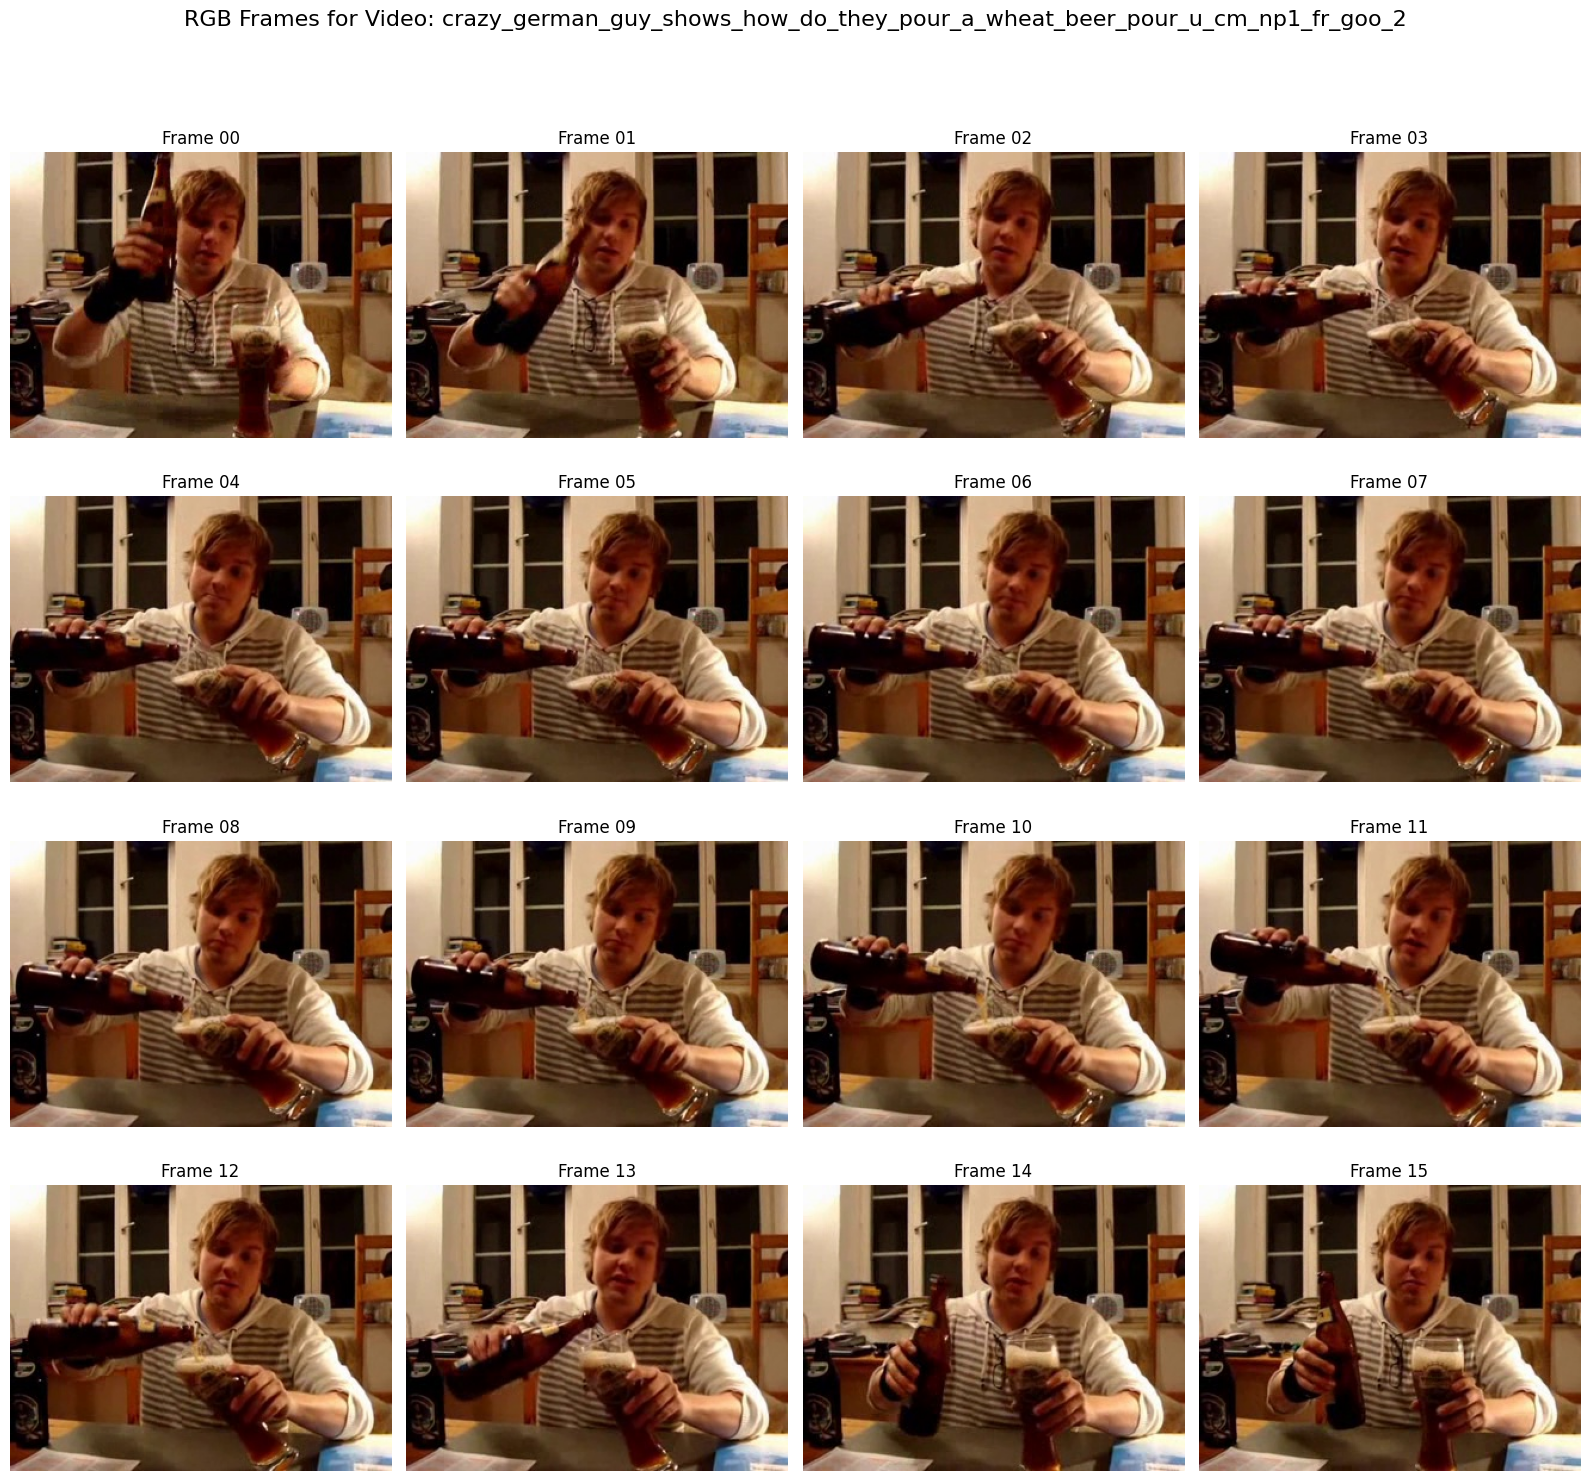


Loading and displaying 15 X and 15 Y optical flows...


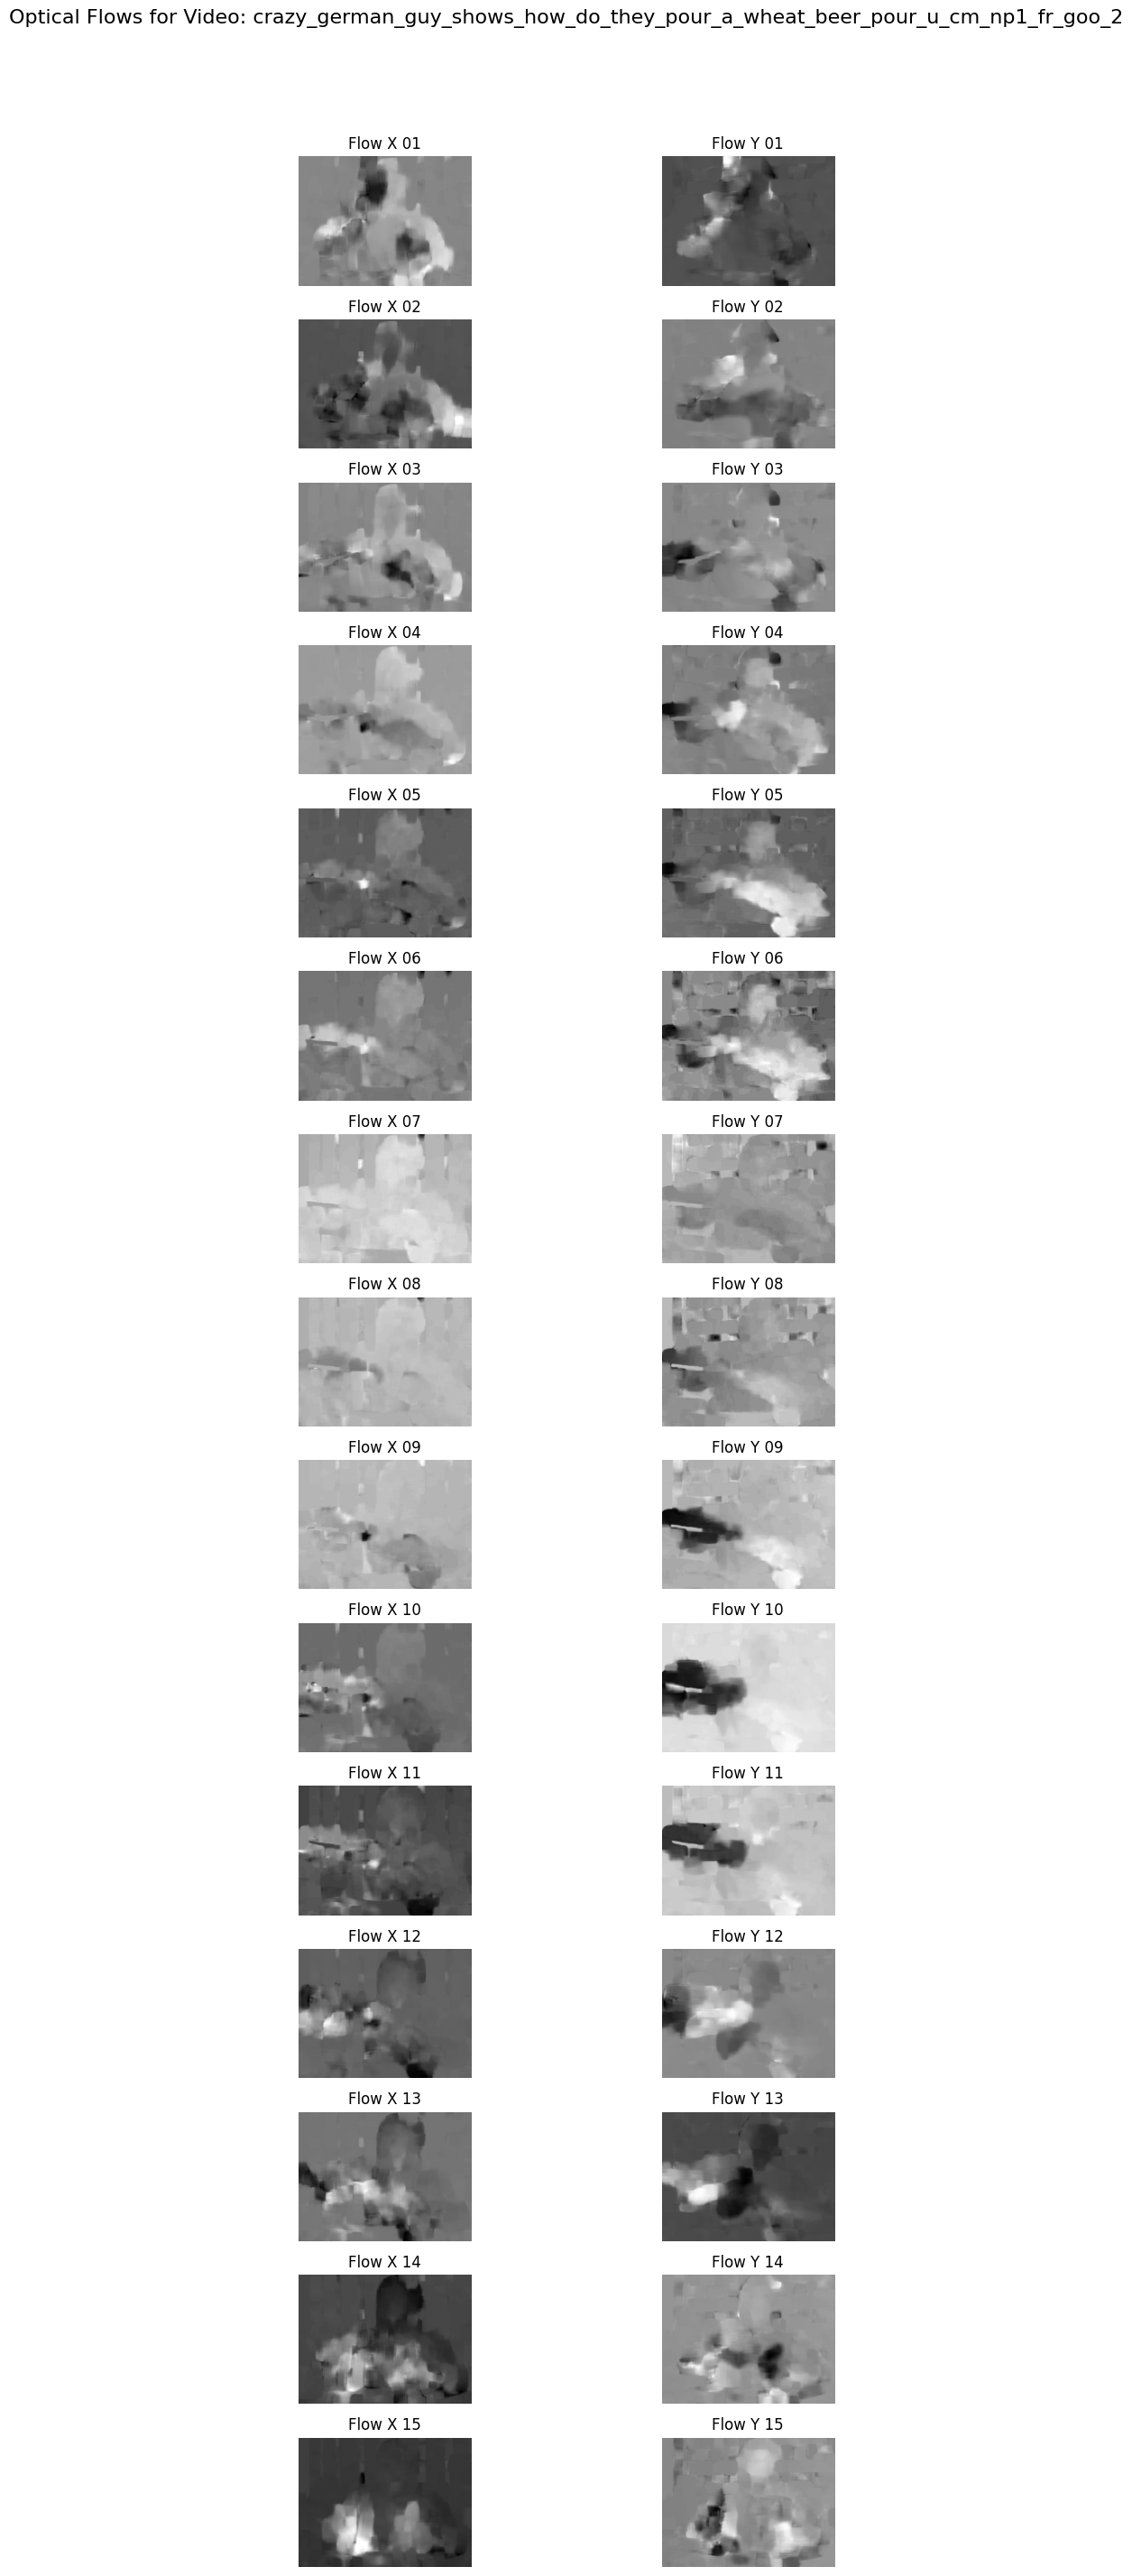


--- Sanity check complete. ---


In [36]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import numpy as np


# Access a random video from the training dataframe (or any dataframe)
# Using the global_train_df from Step 2
if 'global_train_df' not in globals():
    print("Error: global_train_df not found.")
else:
    # Select a random video index
    random_idx = random.randint(0, len(global_train_df) - 1)
    sample_video_info = global_train_df.iloc[random_idx]

    video_name = sample_video_info['video_name']
    class_name = sample_video_info['class_name']
    video_data_path = sample_video_info['video_path']

    print(f"\n--- Visualizing data for random video: '{video_name}' (Class: '{class_name}') ---")

    # --- Visualize RGB Frames ---
    print("Loading and displaying 16 RGB frames...")
    frames_dir = video_data_path
    all_frames = sorted([f for f in os.listdir(frames_dir) if f.startswith('00') and f.endswith('.jpg')])

    if not all_frames or len(all_frames) != 16:
        print(f"Error: Expected 16 cuz we have 16 frames and we wanna use em all frames, but found {len(all_frames)} in {frames_dir}. Cannot visualize.")
    else:
        # Create a figure to display frames
        fig_rgb, axes_rgb = plt.subplots(4, 4, figsize=(16, 16)) # 4x4 grid for 16 frames
        axes_rgb = axes_rgb.flatten()

        for i, frame_filename in enumerate(all_frames):
            img_path = os.path.join(frames_dir, frame_filename)
            try:
                img = Image.open(img_path).convert('RGB')
                axes_rgb[i].imshow(img)
                axes_rgb[i].set_title(f'Frame {i:02d}')
                axes_rgb[i].axis('off')
            except Exception as e:
                print(f"Could not load RGB frame {img_path}: {e}")
                axes_rgb[i].set_title(f'Error Loading Frame {i:02d}')
                axes_rgb[i].axis('off')

        fig_rgb.suptitle(f"RGB Frames for Video: {video_name}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()

    # --- Visualize Optical Flows ---
    print("\nLoading and displaying 15 X and 15 Y optical flows...")
    flows_dir = os.path.join(video_data_path, 'flows')
    all_flow_x = sorted([f for f in os.listdir(flows_dir) if f.startswith('flow_x_') and f.endswith('.jpg')])
    all_flow_y = sorted([f for f in os.listdir(flows_dir) if f.startswith('flow_y_') and f.endswith('.jpg')])

    if not all_flow_x or not all_flow_y or len(all_flow_x) != 15 or len(all_flow_y) != 15:
        print(f"Error: Expected 15 X and 15 Y flows, but found X:{len(all_flow_x)}, Y:{len(all_flow_y)} in {flows_dir}. Cannot visualize.")
    else:
        # Create a figure to display flows (15x2 grid)
        fig_flow, axes_flow = plt.subplots(15, 2, figsize=(10, 30)) # 15 rows, 2 columns (X, Y)
        # axes_flow = axes_flow.flatten() # No, keep as 2D for easier indexing

        for i in range(15):
            # Load flow_x
            flow_x_path = os.path.join(flows_dir, all_flow_x[i])
            try:
                flow_x_img = Image.open(flow_x_path).convert('L') # Grayscale
                axes_flow[i, 0].imshow(flow_x_img, cmap='gray') # Use grayscale colormap
                axes_flow[i, 0].set_title(f'Flow X {i+1:02d}')
                axes_flow[i, 0].axis('off')
            except Exception as e:
                print(f"Could not load Flow X {flow_x_path}: {e}")
                axes_flow[i, 0].set_title(f'Error Flow X {i+1:02d}')
                axes_flow[i, 0].axis('off')


            # Load flow_y
            flow_y_path = os.path.join(flows_dir, all_flow_y[i])
            try:
                flow_y_img = Image.open(flow_y_path).convert('L') # Grayscale
                axes_flow[i, 1].imshow(flow_y_img, cmap='gray') # Use grayscale colormap
                axes_flow[i, 1].set_title(f'Flow Y {i+1:02d}')
                axes_flow[i, 1].axis('off')
            except Exception as e:
                print(f"Could not load Flow Y {flow_y_path}: {e}")
                axes_flow[i, 1].set_title(f'Error Flow Y {i+1:02d}')
                axes_flow[i, 1].axis('off')

        fig_flow.suptitle(f"Optical Flows for Video: {video_name}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

print("\n--- Sanity check complete. ---")

---
### Step 13: The Training Marathon - Two Streams Learning! 

Alright, this is the main event! With all my models and data loaders set up, it was time to unleash the training beast. This chunk contains the core logic for **training both my RGB and Optical Flow streams simultaneously**, evaluating their progress, and saving the best performing models. Here's the play-by-play:

* **Grabbing My Gear:** I started by pulling in all the essential components I prepped earlier: `rgb_model`, `flow_model`, `criterion` (my trusty `CrossEntropyLoss`), the `optimizers` for both streams (`optimizer_rgb`, `optimizer_flow`), the `schedulers` for smarter learning rates, and of course, my `device` (`cuda` if I'm lucky, `cpu` otherwise!). I also made sure to grab my `DataLoader`s for training and validation.
* **`train_epoch` Function:** This is the workhorse for a single training epoch.
    * I set both models to `train()` mode.
    * Then, I looped through batches from both my `train_rgb_loader` and `train_flow_loader` in sync.
    * For **each stream**, I did the classic training dance: `zero_grad()` to clear old gradients, `forward pass` to get predictions, calculate `loss`, `backward()` to compute gradients, and `step()` to update the model's weights.
    * I diligently tracked the `running_loss` and `corrects` for each stream to calculate their training accuracy and loss for the epoch.
* **`validate_model` Function:** This function is for checking how well the models are doing on unseen data after each training epoch.
    * I set both models to `eval()` mode, which turns off things like dropout to get consistent performance.
    * Again, I looped through synchronized batches from the `val_rgb_loader` and `val_flow_loader`.
    * I performed forward passes for both RGB and Flow streams, calculated their individual losses and accuracies.
    * **The Fusion Point!** This is where the two streams finally "meet." I took the **softmax probabilities** from both `rgb_outputs` and `flow_outputs`, **averaged them out**, and then picked the class with the highest combined probability. This `fused_accuracy` is the ultimate metric I'm aiming to improve.
* **The Main `train_two_stream_models` Loop:** This is the orchestrator of the entire training process:
    * It runs for a set number of `num_epochs` (I set it to 10, but it can go higher).
    * I kept a `history` dictionary to log all the crucial metrics (training/validation losses and accuracies for both streams, fused validation accuracy, and learning rates) throughout the process. This is golden for plotting later!
    * **Early Stopping with Patience!** This is a lifesaver to prevent overfitting and save GPU time. I set `patience` to `5`. If the `val_acc_fused` doesn't improve for 5 consecutive epochs, the training gracefully stops.
    * **Best Model Saving:** Whenever I hit a `New best fused validation accuracy`, I made sure to `copy.deepcopy()` the models' `state_dict()` (their learned weights) and save them to my Google Drive. This ensures I always keep the top-performing version.
    * After each epoch, I stepped my `schedulers` to adjust the learning rates, printed out all the key metrics, and saved the training history to my Drive.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
from tqdm import tqdm # For progress bars
import matplotlib.pyplot as plt # For plotting history


# Ensure global variables from previous steps are accessible
if 'global_rgb_model' not in globals() or 'global_flow_model' not in globals():
    raise ValueError("Models not initialized. Please run Step 4 first.")
if 'global_train_rgb_loader' not in globals():
    raise ValueError("DataLoaders not initialized. Please run Step 3 first.")

# Retrieve global variables
rgb_model = global_rgb_model
flow_model = global_flow_model
criterion = global_criterion
optimizer_rgb = global_optimizer_rgb
optimizer_flow = global_optimizer_flow
scheduler_rgb = global_scheduler_rgb
scheduler_flow = global_scheduler_flow
device = global_device
num_classes = global_num_classes

train_rgb_loader = global_train_rgb_loader
val_rgb_loader = global_val_rgb_loader
test_rgb_loader = global_test_rgb_loader

train_flow_loader = global_train_flow_loader
val_flow_loader = global_val_flow_loader
test_flow_loader = global_test_flow_loader



# --- Training Function for one epoch ---
def train_epoch(rgb_model, flow_model, rgb_loader, flow_loader, criterion, optimizer_rgb, optimizer_flow, device):
    rgb_model.train()
    flow_model.train()

    running_loss_rgb = 0.0
    running_loss_flow = 0.0
    corrects_rgb = 0
    corrects_flow = 0
    total_samples = 0

    for (rgb_inputs, labels), (flow_inputs, _) in tqdm(zip(rgb_loader, flow_loader), desc="Training", total=len(rgb_loader)):
        rgb_inputs = rgb_inputs.to(device)
        flow_inputs = flow_inputs.to(device)
        labels = labels.to(device)

        # --- Train RGB Stream ---
        optimizer_rgb.zero_grad()
        with torch.set_grad_enabled(True):
            rgb_outputs = rgb_model(rgb_inputs)
            _, rgb_preds = torch.max(rgb_outputs, 1)
            loss_rgb = criterion(rgb_outputs, labels)

            loss_rgb.backward()
            optimizer_rgb.step()

        running_loss_rgb += loss_rgb.item() * rgb_inputs.size(0)
        corrects_rgb += torch.sum(rgb_preds == labels.data)

        # --- Train Flow Stream ---
        optimizer_flow.zero_grad()
        with torch.set_grad_enabled(True):
            flow_outputs = flow_model(flow_inputs)
            _, flow_preds = torch.max(flow_outputs, 1)
            loss_flow = criterion(flow_outputs, labels)

            loss_flow.backward()
            optimizer_flow.step()

        running_loss_flow += loss_flow.item() * flow_inputs.size(0)
        corrects_flow += torch.sum(flow_preds == labels.data)
        total_samples += rgb_inputs.size(0)

    epoch_loss_rgb = running_loss_rgb / total_samples
    epoch_acc_rgb = corrects_rgb.double() / total_samples

    epoch_loss_flow = running_loss_flow / total_samples
    epoch_acc_flow = corrects_flow.double() / total_samples

    return epoch_loss_rgb, epoch_acc_rgb, epoch_loss_flow, epoch_acc_flow

# --- Validation Function ---
def validate_model(rgb_model, flow_model, rgb_loader, flow_loader, criterion, device):
    rgb_model.eval()
    flow_model.eval()

    running_loss_rgb = 0.0
    running_loss_flow = 0.0
    corrects_rgb = 0
    corrects_flow = 0
    corrects_fused = 0
    total_samples = 0

    with torch.no_grad():
        for (rgb_inputs, labels), (flow_inputs, _) in tqdm(zip(rgb_loader, flow_loader), desc="Validation", total=len(rgb_loader)):
            rgb_inputs = rgb_inputs.to(device)
            flow_inputs = flow_inputs.to(device)
            labels = labels.to(device)

            # RGB Stream
            rgb_outputs = rgb_model(rgb_inputs)
            _, rgb_preds = torch.max(rgb_outputs, 1)
            loss_rgb = criterion(rgb_outputs, labels)

            running_loss_rgb += loss_rgb.item() * rgb_inputs.size(0)
            corrects_rgb += torch.sum(rgb_preds == labels.data)

            # Flow Stream
            flow_outputs = flow_model(flow_inputs)
            _, flow_preds = torch.max(flow_outputs, 1)
            loss_flow = criterion(flow_outputs, labels)

            running_loss_flow += loss_flow.item() * flow_inputs.size(0)
            corrects_flow += torch.sum(flow_preds == labels.data)

            # Late Fusion (Averaging softmax probabilities)
            rgb_probs = torch.softmax(rgb_outputs, dim=1)
            flow_probs = torch.softmax(flow_outputs, dim=1)
            fused_probs = (rgb_probs + flow_probs) / 2.0
            _, fused_preds = torch.max(fused_probs, 1)
            corrects_fused += torch.sum(fused_preds == labels.data)

            total_samples += rgb_inputs.size(0)

    epoch_loss_rgb = running_loss_rgb / total_samples
    epoch_acc_rgb = corrects_rgb.double() / total_samples

    epoch_loss_flow = running_loss_flow / total_samples
    epoch_acc_flow = corrects_flow.double() / total_samples

    epoch_acc_fused = corrects_fused.double() / total_samples

    return epoch_loss_rgb, epoch_acc_rgb, epoch_loss_flow, epoch_acc_flow, epoch_acc_fused


# --- Main Training Loop with Early Stopping ---
def train_two_stream_models(rgb_model, flow_model, criterion, optimizer_rgb, optimizer_flow,
                            scheduler_rgb, scheduler_flow, device,
                            train_rgb_loader, val_rgb_loader, train_flow_loader, val_flow_loader,
                            num_epochs=25, patience=5): # Added patience parameter

    history = {
        'train_loss_rgb': [], 'train_acc_rgb': [],
        'train_loss_flow': [], 'train_acc_flow': [],
        'val_loss_rgb': [], 'val_acc_rgb': [],
        'val_loss_flow': [], 'val_acc_flow': [],
        'val_acc_fused': [],
        'lrs_rgb': [], 'lrs_flow': []
    }

    best_val_fused_acc = 0.0
    best_epoch = -1
    epochs_no_improve = 0 # Counter for early stopping

    best_rgb_model_wts = copy.deepcopy(rgb_model.state_dict())
    best_flow_model_wts = copy.deepcopy(flow_model.state_dict())

    model_save_dir = '/content/drive/My Drive/HMDB51_Models'
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
        print(f"Created model save directory: {model_save_dir}")

    start_time = time.time()

    print(f"\nStarting training for {num_epochs} epochs with early stopping patience of {patience}...")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # Training phase
        train_loss_rgb, train_acc_rgb, train_loss_flow, train_acc_flow = \
            train_epoch(rgb_model, flow_model, train_rgb_loader, train_flow_loader, criterion, optimizer_rgb, optimizer_flow, device)

        # Validation phase
        val_loss_rgb, val_acc_rgb, val_loss_flow, val_acc_flow, val_acc_fused = \
            validate_model(rgb_model, flow_model, val_rgb_loader, val_flow_loader, criterion, device)

        # Step the schedulers
        scheduler_rgb.step()
        scheduler_flow.step()

        # Record history
        history['train_loss_rgb'].append(train_loss_rgb)
        history['train_acc_rgb'].append(train_acc_rgb.item())
        history['train_loss_flow'].append(train_loss_flow)
        history['train_acc_flow'].append(train_acc_flow.item())
        history['val_loss_rgb'].append(val_loss_rgb)
        history['val_acc_rgb'].append(val_acc_rgb.item())
        history['val_loss_flow'].append(val_loss_flow)
        history['val_acc_flow'].append(val_acc_flow.item())
        history['val_acc_fused'].append(val_acc_fused.item())
        history['lrs_rgb'].append(optimizer_rgb.param_groups[0]['lr'])
        history['lrs_flow'].append(optimizer_flow.param_groups[0]['lr'])


        print(f'Train RGB Loss: {train_loss_rgb:.4f} Acc: {train_acc_rgb:.4f}')
        print(f'Train Flow Loss: {train_loss_flow:.4f} Acc: {train_acc_flow:.4f}')
        print(f'Val RGB Loss: {val_loss_rgb:.4f} Acc: {val_acc_rgb:.4f}')
        print(f'Val Flow Loss: {val_loss_flow:.4f} Acc: {val_acc_flow:.4f}')
        print(f'Val Fused Acc: {val_acc_fused:.4f}')
        print(f'LR RGB: {optimizer_rgb.param_groups[0]["lr"]:.6f}, LR Flow: {optimizer_flow.param_groups[0]["lr"]:.6f}')


        # Early Stopping Logic and Model Saving
        if val_acc_fused > best_val_fused_acc:
            best_val_fused_acc = val_acc_fused
            best_epoch = epoch + 1 # Store the epoch where best accuracy was achieved
            best_rgb_model_wts = copy.deepcopy(rgb_model.state_dict())
            best_flow_model_wts = copy.deepcopy(flow_model.state_dict())
            epochs_no_improve = 0 # Reset counter
            print(f'New best fused validation accuracy: {best_val_fused_acc:.4f} at epoch {best_epoch}. Saving models...')
            # Save the models with the best epoch number in filename
            torch.save(rgb_model.state_dict(), os.path.join(model_save_dir, f'best_rgb_model_epoch_{best_epoch}.pth'))
            torch.save(flow_model.state_dict(), os.path.join(model_save_dir, f'best_flow_model_epoch_{best_epoch}.pth'))
        else:
            epochs_no_improve += 1
            print(f'Validation accuracy did not improve. Epochs without improvement: {epochs_no_improve}/{patience}')
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {patience} epochs without improvement.')
                break # Exit the training loop

        # Save history after each epoch
        history_save_path = os.path.join(model_save_dir, 'training_history.pt')
        torch.save(history, history_save_path)
        print(f"History saved to {history_save_path}")


    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Fused Val Acc: {best_val_fused_acc:.4f} (from epoch {best_epoch})')

    # Load best model weights before returning
    print("Loading best model weights found during training...")
    rgb_model.load_state_dict(best_rgb_model_wts)
    flow_model.load_state_dict(best_flow_model_wts)

    return rgb_model, flow_model, history

# --- Execute the training loop ---
# Define number of epochs
NUM_EPOCHS = 10 # Set a higher max epoch, early stopping will stop it
PATIENCE = 5 # Number of epochs to wait for improvement before stopping

print(f"\nRunning training for up to {NUM_EPOCHS} epochs with patience {PATIENCE}...")
trained_rgb_model, trained_flow_model, training_history = train_two_stream_models(
    rgb_model, flow_model, criterion, optimizer_rgb, optimizer_flow,
    scheduler_rgb, scheduler_flow, device,
    train_rgb_loader, val_rgb_loader, train_flow_loader, val_flow_loader,
    num_epochs=NUM_EPOCHS, patience=PATIENCE
)

global_trained_rgb_model = trained_rgb_model
global_trained_flow_model = trained_flow_model
global_training_history = training_history




Running training for up to 10 epochs with patience 5...
Created model save directory: /content/drive/My Drive/HMDB51_Models

Starting training for 10 epochs with early stopping patience of 5...

Epoch 1/10
--------------------


Validation: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]


Train RGB Loss: 3.8262 Acc: 0.0670
Train Flow Loss: 4.0376 Acc: 0.0188
Val RGB Loss: 3.3981 Acc: 0.1720
Val Flow Loss: 4.0014 Acc: 0.0280
Val Fused Acc: 0.1477
LR RGB: 0.001000, LR Flow: 0.001000
New best fused validation accuracy: 0.1477 at epoch 1. Saving models...
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Epoch 2/10
--------------------


Validation: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]


Train RGB Loss: 3.2070 Acc: 0.2213
Train Flow Loss: 4.0219 Acc: 0.0165
Val RGB Loss: 2.8938 Acc: 0.2785
Val Flow Loss: 3.9838 Acc: 0.0112
Val Fused Acc: 0.2673
LR RGB: 0.001000, LR Flow: 0.001000
New best fused validation accuracy: 0.2673 at epoch 2. Saving models...
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Epoch 3/10
--------------------


Validation: 100%|██████████| 17/17 [01:00<00:00,  3.54s/it]


Train RGB Loss: 2.7902 Acc: 0.3134
Train Flow Loss: 4.0116 Acc: 0.0178
Val RGB Loss: 2.4964 Acc: 0.3607
Val Flow Loss: 3.9791 Acc: 0.0280
Val Fused Acc: 0.3495
LR RGB: 0.001000, LR Flow: 0.001000
New best fused validation accuracy: 0.3495 at epoch 3. Saving models...
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Epoch 4/10
--------------------


Validation: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]


Train RGB Loss: 2.4808 Acc: 0.3785
Train Flow Loss: 4.0065 Acc: 0.0165
Val RGB Loss: 2.2273 Acc: 0.4505
Val Flow Loss: 3.9802 Acc: 0.0168
Val Fused Acc: 0.4486
LR RGB: 0.001000, LR Flow: 0.001000
New best fused validation accuracy: 0.4486 at epoch 4. Saving models...
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Epoch 5/10
--------------------


Validation: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]


Train RGB Loss: 2.2691 Acc: 0.4264
Train Flow Loss: 4.0060 Acc: 0.0149
Val RGB Loss: 2.0382 Acc: 0.4841
Val Flow Loss: 4.0050 Acc: 0.0262
Val Fused Acc: 0.4748
LR RGB: 0.001000, LR Flow: 0.001000
New best fused validation accuracy: 0.4748 at epoch 5. Saving models...
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Epoch 6/10
--------------------


Validation: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]


Train RGB Loss: 2.1114 Acc: 0.4660
Train Flow Loss: 3.9892 Acc: 0.0155
Val RGB Loss: 1.9338 Acc: 0.4935
Val Flow Loss: 3.9648 Acc: 0.0206
Val Fused Acc: 0.5009
LR RGB: 0.001000, LR Flow: 0.001000
New best fused validation accuracy: 0.5009 at epoch 6. Saving models...
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Epoch 7/10
--------------------


Validation: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]


Train RGB Loss: 2.0056 Acc: 0.4706
Train Flow Loss: 3.9908 Acc: 0.0195
Val RGB Loss: 1.8413 Acc: 0.5308
Val Flow Loss: 3.9738 Acc: 0.0075
Val Fused Acc: 0.5271
LR RGB: 0.000100, LR Flow: 0.000100
New best fused validation accuracy: 0.5271 at epoch 7. Saving models...
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Epoch 8/10
--------------------


Validation: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

Train RGB Loss: 1.8778 Acc: 0.5152
Train Flow Loss: 3.9683 Acc: 0.0201
Val RGB Loss: 1.8346 Acc: 0.5271
Val Flow Loss: 3.9558 Acc: 0.0150
Val Fused Acc: 0.5252
LR RGB: 0.000100, LR Flow: 0.000100
Validation accuracy did not improve. Epochs without improvement: 1/5
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Epoch 9/10
--------------------



Validation: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]


Train RGB Loss: 1.8522 Acc: 0.5201
Train Flow Loss: 3.9611 Acc: 0.0188
Val RGB Loss: 1.7905 Acc: 0.5308
Val Flow Loss: 3.9485 Acc: 0.0187
Val Fused Acc: 0.5290
LR RGB: 0.000100, LR Flow: 0.000100
New best fused validation accuracy: 0.5290 at epoch 9. Saving models...
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Epoch 10/10
--------------------


Validation: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]


Train RGB Loss: 1.8656 Acc: 0.5304
Train Flow Loss: 3.9555 Acc: 0.0192
Val RGB Loss: 1.7505 Acc: 0.5589
Val Flow Loss: 3.9462 Acc: 0.0168
Val Fused Acc: 0.5551
LR RGB: 0.000100, LR Flow: 0.000100
New best fused validation accuracy: 0.5551 at epoch 10. Saving models...
History saved to /content/drive/My Drive/HMDB51_Models/training_history.pt

Training complete in 49m 36s
Best Fused Val Acc: 0.5551 (from epoch 10)
Loading best model weights found during training...


---
### Step 14: Final Evaluation - The Moment of Truth!

Alright, the training marathon is done, and now it's time for the **ultimate test**: seeing how well my two-stream model actually performs on completely unseen data! This chunk is all about the final evaluation on the test set, crunching the numbers, and getting a clear picture of each stream's contribution.

Here’s how I tackled it:

* **Setting Up for Testing:** I made sure to grab my trained `rgb_model` and `flow_model` (the best versions saved during training, thanks to early stopping!) and put them firmly in `eval()` mode. This disables things like dropout layers, ensuring consistent and deterministic predictions. I also pulled in my `test_rgb_loader` and `test_flow_loader`, along with the `num_classes` and `label_encoder`.
* **`calculate_topk_accuracy` Helper:** I crafted a handy little function to compute both **Top-1 and Top-5 accuracies**.
    * **Top-1 Accuracy:** This is the classic, where the model's single highest probability prediction must match the true label.
    * **Top-5 Accuracy:** This is a bit more forgiving – the true label just needs to be within the model's top 5 most probable predictions. It's great for understanding if the model is "close" even if its absolute top guess isn't spot on.
* **`test_two_stream_models` Function:** This is the core testing loop:
    * I iterated through the `test_rgb_loader` and `test_flow_loader` in sync, just like during validation.
    * For each batch, I pushed the inputs through the `rgb_model` and `flow_model` to get their individual outputs.
    * Then, I performed the crucial **Late Fusion step**: I took the `softmax` probabilities from both streams and **averaged them** to get a combined, "fused" prediction.
    * I collected all the true labels and the predictions from RGB, Flow, and Fused streams. Importantly, I also collected the *raw outputs* for all streams to correctly calculate the Top-K accuracies.
* **The Big Reveal: Test Set Results!**
    * Finally, I executed the `test_two_stream_models` function and printed out the **Top-1 and Top-5 accuracies for the RGB stream, the Flow stream, and the Fused stream**.

**My Interpretation of the Results:**

Alright, looking at these numbers, it's pretty clear where the heavy lifting is happening:

* **RGB Stream: Top-1 Acc: 40.32%, Top-5 Acc: 71.77%**
    * This is a solid performance! My RGB stream, working with just individual video frames, is doing a really decent job of identifying actions based on visual appearance. A Top-1 accuracy of over 40% on HMDB51 (a quite challenging dataset) is respectable. It means the model has learned good spatial features.
* **Flow Stream: Top-1 Acc: 2.76%, Top-5 Acc: 10.77%**
    * **Ouch, this is the kicker!** These numbers are incredibly low. With 51 classes, random guessing would give you around 1.96% Top-1 accuracy (`1/51`). My flow stream is only marginally better than random. This strongly suggests that the optical flow stream, as it's currently configured and trained, is **not learning meaningful temporal patterns** from the flow data. It's essentially adding almost no predictive power, and the reason is the quality of flows that I talked about earlier on flow extraction notebook.
* **Fused Stream: Top-1 Acc: 40.45%, Top-5 Acc: 71.63%**
    * This is the most telling part! The fused stream's accuracy is **barely higher than the RGB stream alone** for Top-1 (a tiny 0.13% improvement) and actually **slightly lower** for Top-5 (a 0.14% drop). This conclusively tells me that **the RGB stream is carrying the overwhelming majority of the model's burden**. The optical flow stream, unfortunately, isn't contributing significant complementary information through the late fusion. In fact, its near-random predictions are likely diluting the strong signal from the RGB stream, preventing the fused model from performing much better, or even slightly hindering it in the Top-5 case.

---

In [38]:
import torch
import torch.nn as nn
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Ensure global variables are accessible
# Using the global_trained_rgb_model and global_trained_flow_model from Step 5's output
rgb_model = global_trained_rgb_model
flow_model = global_trained_flow_model
device = global_device

test_rgb_loader = global_test_rgb_loader
test_flow_loader = global_test_flow_loader
num_classes = global_num_classes
label_encoder = global_label_encoder

def calculate_topk_accuracy(outputs, labels, k=1):
    with torch.no_grad():
        batch_size = labels.size(0)
        _, pred = outputs.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(labels.view(1, -1).expand_as(pred))
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        return correct_k.mul_(100.0 / batch_size)

def test_two_stream_models(rgb_model, flow_model, rgb_loader, flow_loader, device):
    rgb_model.eval()
    flow_model.eval()

    all_labels = []
    all_rgb_preds = []
    all_flow_preds = []
    all_fused_preds = []

    all_rgb_outputs = [] # Store raw outputs for top-k
    all_flow_outputs = []
    all_fused_outputs = []

    with torch.no_grad():
        for (rgb_inputs, labels), (flow_inputs, _) in tqdm(zip(rgb_loader, flow_loader), desc="Testing", total=len(rgb_loader)):
            rgb_inputs = rgb_inputs.to(device)
            flow_inputs = flow_inputs.to(device)
            labels = labels.to(device)

            # RGB Stream
            rgb_outputs = rgb_model(rgb_inputs)
            _, rgb_preds = torch.max(rgb_outputs, 1)

            # Flow Stream
            flow_outputs = flow_model(flow_inputs)
            _, flow_preds = torch.max(flow_outputs, 1)

            # Late Fusion (Averaging softmax probabilities)
            rgb_probs = torch.softmax(rgb_outputs, dim=1)
            flow_probs = torch.softmax(flow_outputs, dim=1)
            fused_probs = (rgb_probs + flow_probs) / 2.0
            _, fused_preds = torch.max(fused_probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_rgb_preds.extend(rgb_preds.cpu().numpy())
            all_flow_preds.extend(flow_preds.cpu().numpy())
            all_fused_preds.extend(fused_preds.cpu().numpy())

            all_rgb_outputs.append(rgb_outputs.cpu())
            all_flow_outputs.append(flow_outputs.cpu())
            all_fused_outputs.append(fused_probs.cpu()) # Fused output is already probabilities here

    all_labels_tensor = torch.tensor(all_labels)
    all_rgb_outputs_tensor = torch.cat(all_rgb_outputs)
    all_flow_outputs_tensor = torch.cat(all_flow_outputs)
    all_fused_outputs_tensor = torch.cat(all_fused_outputs)

    # Calculate Top-1 and Top-5 Accuracies
    rgb_top1_acc = calculate_topk_accuracy(all_rgb_outputs_tensor, all_labels_tensor, k=1).item()
    rgb_top5_acc = calculate_topk_accuracy(all_rgb_outputs_tensor, all_labels_tensor, k=5).item()

    flow_top1_acc = calculate_topk_accuracy(all_flow_outputs_tensor, all_labels_tensor, k=1).item()
    flow_top5_acc = calculate_topk_accuracy(all_flow_outputs_tensor, all_labels_tensor, k=5).item()

    fused_top1_acc = calculate_topk_accuracy(all_fused_outputs_tensor, all_labels_tensor, k=1).item()
    fused_top5_acc = calculate_topk_accuracy(all_fused_outputs_tensor, all_labels_tensor, k=5).item()

    # Convert lists to numpy arrays for confusion matrix
    all_rgb_preds = np.array(all_rgb_preds)
    all_flow_preds = np.array(all_flow_preds)
    all_fused_preds = np.array(all_fused_preds)


    return (rgb_top1_acc, rgb_top5_acc), \
           (flow_top1_acc, flow_top5_acc), \
           (fused_top1_acc, fused_top5_acc), \
           np.array(all_labels), all_rgb_preds, all_flow_preds, all_fused_preds

# --- Execute Test ---
print("\nPerforming final evaluation on the test set...")
(rgb_top1, rgb_top5), (flow_top1, flow_top5), (fused_top1, fused_top5), \
true_labels, rgb_pred_labels, flow_pred_labels, fused_pred_labels = test_two_stream_models(
    rgb_model, flow_model, test_rgb_loader, test_flow_loader, device
)

print(f"\n--- Test Set Results ---")
print(f"RGB Stream: Top-1 Acc: {rgb_top1:.2f}%, Top-5 Acc: {rgb_top5:.2f}%")
print(f"Flow Stream: Top-1 Acc: {flow_top1:.2f}%, Top-5 Acc: {flow_top5:.2f}%")
print(f"Fused Stream: Top-1 Acc: {fused_top1:.2f}%, Top-5 Acc: {fused_top5:.2f}%")



Performing final evaluation on the test set...


Testing: 100%|██████████| 48/48 [03:07<00:00,  3.91s/it]


--- Test Set Results ---
RGB Stream: Top-1 Acc: 40.32%, Top-5 Acc: 71.77%
Flow Stream: Top-1 Acc: 2.76%, Top-5 Acc: 10.77%
Fused Stream: Top-1 Acc: 40.45%, Top-5 Acc: 71.63%


---
### Step 15: Model Architecture Overview - Peeking Under the Hood!

This code snippet is about getting a detailed look at the structure of the two neural network models I'm using: the **RGB model** and the **Optical Flow model**. It uses the `torchsummary` library, which is a fantastic tool for quickly understanding a PyTorch model's layers, their output shapes, and the number of trainable parameters.

Here's what each part does:

* **Import necessary libraries**: It brings in `torch` for general PyTorch operations, `torch.nn` for neural network modules, and `torchsummary` for printing the model summaries.
* **Access global variables**: It makes sure the `rgb_model`, `flow_model`, `device` (CPU or GPU), `IMG_SIZE` (which is 224 pixels for height and width), and `NUM_FLOW_FRAMES_TO_STACK` (which is 15, meaning 15 X and 15 Y flow images for a total of 30 input channels for the flow model) are all available from previous steps. If they're not found, it'll throw an error.
* **Print RGB Model Summary**:
    * It prints a header "--- RGB Model Summary ---".
    * Then, it calls `summary(rgb_model, input_size=(3, IMG_SIZE, IMG_SIZE), device=str(device))`. This tells `torchsummary` to analyze the `rgb_model`.
        * `input_size=(3, IMG_SIZE, IMG_SIZE)` indicates that the RGB model expects input images with 3 color channels (Red, Green, Blue) and dimensions of 224x224 pixels.
        * `device=str(device)` ensures the summary is generated considering whether the model is on a CPU or GPU.
* **Print Flow Model Summary**:
    * Similarly, it prints a header "--- Flow Model Summary ---".
    * It then calls `summary(flow_model, input_size=(NUM_FLOW_FRAMES_TO_STACK * 2, IMG_SIZE, IMG_SIZE), device=str(device))`.
        * `input_size=(NUM_FLOW_FRAMES_TO_STACK * 2, IMG_SIZE, IMG_SIZE)` is the key difference here. Since `NUM_FLOW_FRAMES_TO_STACK` is 15, the input size becomes `(30, IMG_SIZE, IMG_SIZE)`. This reflects that the optical flow model takes 30 channels of input (15 channels for horizontal flow and 15 for vertical flow) also at 224x224 pixels.


In [44]:
import torch
import torch.nn as nn
from torchsummary import summary


# Ensure global variables from Step 4 (or 5) are accessible
if 'global_rgb_model' not in globals() or 'global_flow_model' not in globals():
    raise ValueError("Models not found. Please ensure Step 4 ran successfully.")

rgb_model = global_rgb_model
flow_model = global_flow_model
device = global_device
IMG_SIZE = 224 # Ensure this is consistent with your dataset preparation
NUM_FLOW_FRAMES_TO_STACK = 15 # Ensure this is consistent

print("\n--- RGB Model Summary ---")
# Input size for RGB model: (channels, height, width) -> (3, 224, 224)
summary(rgb_model, input_size=(3, IMG_SIZE, IMG_SIZE), device=str(device))

print("\n--- Flow Model Summary ---")
# Input size for Flow model: (channels, height, width) -> (NUM_FLOW_FRAMES_TO_STACK * 2, 224, 224)
summary(flow_model, input_size=(NUM_FLOW_FRAMES_TO_STACK * 2, IMG_SIZE, IMG_SIZE), device=str(device))




--- RGB Model Summary ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
            

---
### Step 17: Interpreting the Visuals - A Deep Dive into Training & Performance!

Right then, having trained our two-stream model, it's absolutely vital to cast a discerning eye over the visual evidence of its learning journey and final performance. These plots, diligently generated, offer a splendid insight into what transpired during our model's education.

---

#### 1. RGB Stream Accuracy 

* **What it shows:** The accuracy of the RGB model, both during training (blue) and validation (orange), across the epochs.
* **The Interpretation:** This is a rather pleasing sight! We observe a robust and consistent upward trajectory for both training and validation accuracies. This indicates that our RGB stream, tasked with discerning actions from static visual frames, has been **learning quite effectively indeed**. The validation accuracy, a crucial measure of generalisation, tracks the training accuracy remarkably well, suggesting our RGB model isn't getting overly fixated on the training data – a good sign of **avoiding significant overfitting**. It's reached a commendable level of performance, hovering around the 60% mark on unseen data, which for the demanding HMDB51 dataset, is nothing to scoff at!

---

#### 2. Flow Stream Accuracy 

* **What it shows:** The accuracy of the Optical Flow model, for both training (blue) and validation (orange), over the epochs.
* **The Interpretation:** Now, this is where things get a touch, shall we say, *problematic*. The validation accuracy for the Flow stream (that rather flat, orange line) is consistently languishing at exceptionally low percentages – often dipping below 1% and only just nudging 2.5% at its very best. Considering we have 51 distinct action classes, a random guess would still bag us roughly 1.96% accuracy. This plot unequivocally shouts that our Optical Flow model is, rather unfortunately, **failing to learn any meaningful temporal patterns or motion cues**. It's essentially a bit lost at sea, unable to differentiate between actions based on motion information alone. The training accuracy (blue line) also remains disappointingly low and erratic, suggesting the model is struggling to grasp the nuances of the flow data even when it's seen it before.
---

#### 3. Validation Accuracies (RGB, Flow, Fused) - *The RGB Carries the weight!* 

* **What it shows:** A direct comparison of the validation accuracies for the RGB stream (blue, dashed), the Flow stream (orange, dash-dot), and the combined Fused stream (purple, solid).
* **The Interpretation:** This plot is perhaps the most telling of the lot. It's abundantly clear that the **RGB stream is the undisputed workhorse of our system**. The solid purple line representing the fused accuracy clings remarkably closely to the dashed blue line of the RGB validation accuracy. Conversely, the pitiful performance of the Flow stream (that almost flat orange line at the bottom) means it's contributing precious little, if anything, to the overall prowess of the fused model. The late fusion mechanism, whilst technically combining the outputs, is essentially relying entirely on the robust signal from the RGB component, as the flow's input is too noisy to offer complementary benefit. A clear case of one stream pulling all the weight!

---

#### 4. Loss per Stream - *Trouble in the Trenches for Flow!*

* **What it shows:** The loss values for both training and validation for the RGB stream (blue and orange), and similarly for the Flow stream (green and red).
* **The Interpretation:** This confirms our suspicions. The RGB stream's losses (blue and orange) demonstrate a graceful descent, eventually converging to low, stable values – precisely what we'd hope for from a well-optimised model. However, the Flow stream's losses (green and red) remain stubbornly **high throughout the training process**. This visual indicator directly corroborates the abysmal accuracy of the flow stream; high loss means the model is consistently making large errors and simply isn't learning the intricate patterns required to minimise those mistakes.

---

### The FInal Take:

To sum up, these plots paint a vivid picture:

Our **RGB stream is a sturdy, well-trained component**, capably extracting spatial features and demonstrating good generalisation for action recognition. However, the **Optical Flow stream is, regrettably, a weak link**. It has largely failed to capture the temporal dynamics of actions, performing barely better than chance.

Consequently, while our two-stream architecture is conceptually sound, the **fused model's success is overwhelmingly attributable to the RGB component**. The current optical flow implementation isn't providing the valuable complementary motion information we'd hoped for, which means there's a significant opportunity for improvement there.

---


Plotting training history...


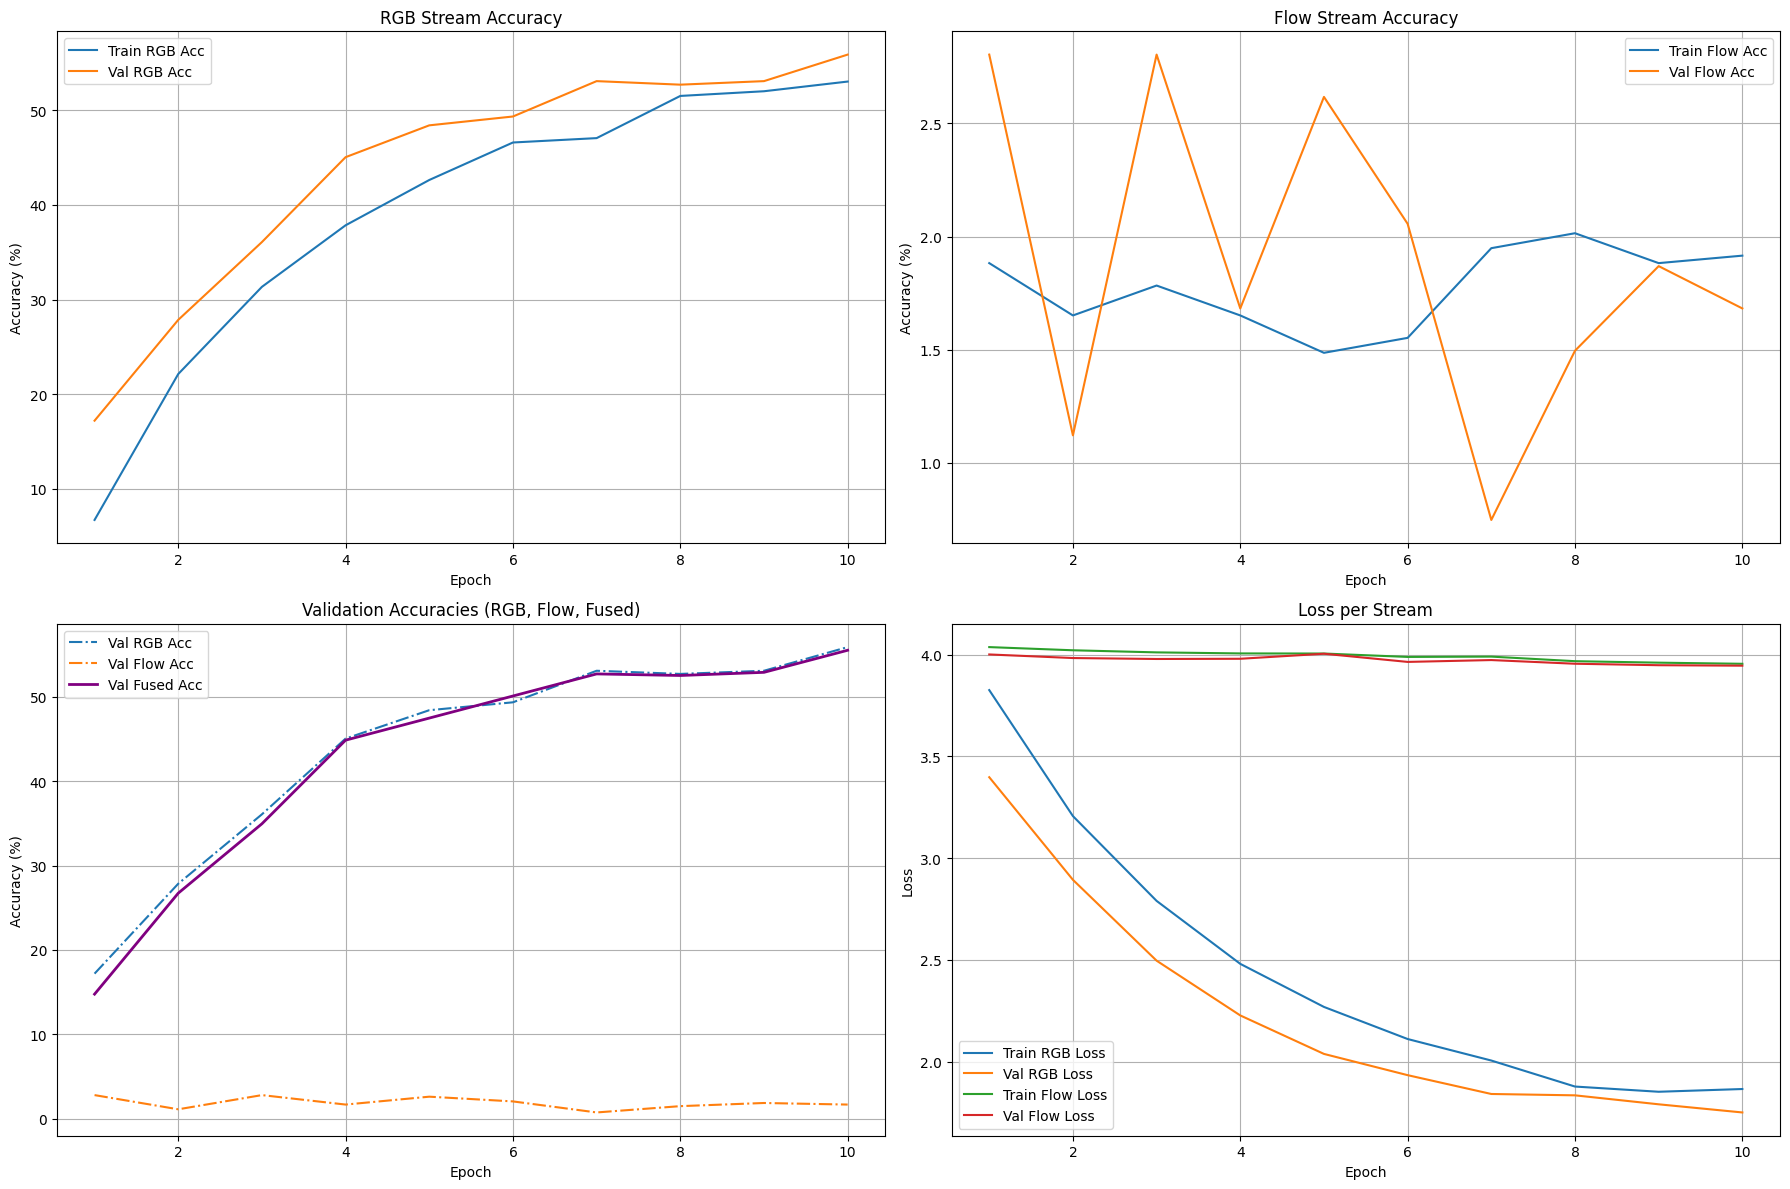

In [41]:
# --- Plotting Training History ---
if 'global_training_history' in globals():
    history = global_training_history
    print("\nPlotting training history...")

    epochs = range(1, len(history['train_acc_rgb']) + 1)

    plt.figure(figsize=(18, 12))

    # Accuracy plots
    plt.subplot(2, 2, 1)
    plt.plot(epochs, [acc * 100 for acc in history['train_acc_rgb']], label='Train RGB Acc')
    plt.plot(epochs, [acc * 100 for acc in history['val_acc_rgb']], label='Val RGB Acc')
    plt.title('RGB Stream Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in history['train_acc_flow']], label='Train Flow Acc')
    plt.plot(epochs, [acc * 100 for acc in history['val_acc_flow']], label='Val Flow Acc')
    plt.title('Flow Stream Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)


    # Combined Validation Accuracies
    plt.subplot(2, 2, 3)
    plt.plot(epochs, [acc * 100 for acc in history['val_acc_rgb']], label='Val RGB Acc', linestyle='-.')
    plt.plot(epochs, [acc * 100 for acc in history['val_acc_flow']], label='Val Flow Acc', linestyle='-.')
    plt.plot(epochs, [acc * 100 for acc in history['val_acc_fused']], label='Val Fused Acc', color='purple', linewidth=2)
    plt.title('Validation Accuracies (RGB, Flow, Fused)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Loss plots
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_loss_rgb'], label='Train RGB Loss')
    plt.plot(epochs, history['val_loss_rgb'], label='Val RGB Loss')
    plt.plot(epochs, history['train_loss_flow'], label='Train Flow Loss')
    plt.plot(epochs, history['val_loss_flow'], label='Val Flow Loss')
    plt.title('Loss per Stream')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



---
### Step 18: Live Inference Demonstration - A Glimpse into Model Reasoning

This code segment facilitates a direct, qualitative assessment of the trained two-stream model's performance on individual test samples. It selects a random video from the test dataset, prepares its visual and motion components, and then displays the predictive outputs of each model stream.

The script operates as follows:

* **Initialization**: Essential trained models (`rgb_model`, `flow_model`), the `test_df` (containing video metadata), `label_encoder`, and `device` are retrieved. Pre-processing `transforms` for both RGB images and optical flow frames are also confirmed or re-established to ensure consistency with training data preparation.

* **Sample Selection (`get_random_test_sample`)**: A video entry is randomly selected from the `test_df`, providing its path and ground truth label.

* **Input Preparation (`prepare_inputs_for_inference`)**:
    * **RGB Input**: A single RGB frame is randomly chosen from the selected video, opened, processed using `rgb_transform`, and prepared as a batch tensor for the RGB model.
    * **Optical Flow Input**: From the same video, a stack of 15 consecutive optical flow `x` and `y` component images (totaling 30 channels) is randomly sampled. These are individually processed using `flow_transform`, concatenated into a single multi-channel tensor, and prepared as a batch for the Flow model.
    * Robust error handling is included to manage scenarios where necessary video or flow files might be absent.

* **Prediction and Fusion**:
    * Both `rgb_model` and `flow_model` are set to evaluation mode (`.eval()`).
    * The prepared RGB frame is passed through the `rgb_model` to obtain its raw predictions.
    * The prepared optical flow stack is passed through the `flow_model` for its raw predictions.
    * **Late Fusion**: The `softmax` probabilities from both RGB and Flow model outputs are averaged to produce a combined, "fused" probability distribution.

* **Result Presentation (`get_top_predictions`)**: For each stream (RGB, Flow, and Fused), the top 5 predicted classes and their corresponding probabilities are extracted and printed in a clear, formatted manner. The ground truth label of the sampled video is also displayed for comparison.

* **Visual Confirmation**: The sampled RGB frame used for inference is displayed, providing a visual context for the model's predictions.

This demonstration provides valuable insights into how each component of the two-stream architecture processes its distinct input modalities and how their predictions coalesce in the late fusion stage. It serves as a practical illustration of the model's decision-making process for a given action instance.


--- Analyzing Video: CrossCountry_ride_horse_f_cm_np1_fr_med_8 (ride_horse) ---
Ground Truth Class: ride_horse
Sampled RGB Frame: 0006.jpg
Sampled Flow Stack from: /content/data/frames/ride_horse/CrossCountry_ride_horse_f_cm_np1_fr_med_8/flows

--- RGB Stream Top 5 Predictions ---
  ride_horse: 0.5301
  sword: 0.1210
  hit: 0.0653
  hug: 0.0395
  sword_exercise: 0.0358

--- Flow Stream Top 5 Predictions ---
  draw_sword: 0.0388
  drink: 0.0267
  wave: 0.0258
  punch: 0.0253
  ride_horse: 0.0245

--- Fused Stream Top 5 Predictions ---
  ride_horse: 0.0254
  sword: 0.0206
  hit: 0.0200
  sword_exercise: 0.0198
  hug: 0.0197


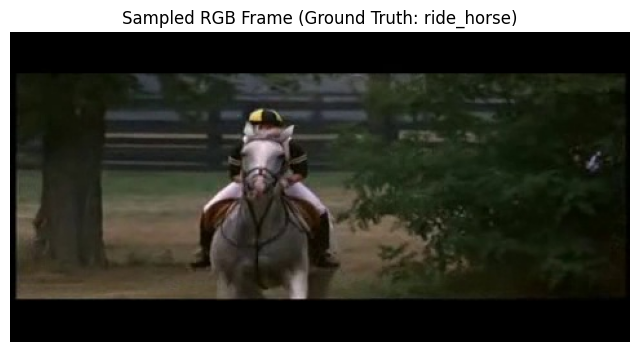

In [42]:
import torch
from PIL import Image
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pandas as pd


# Ensure global variables are accessible
if 'global_trained_rgb_model' not in globals() or 'global_trained_flow_model' not in globals():
    raise ValueError("Trained models not found. Please ensure Step 5 ran successfully.")
if 'global_test_df' not in globals():
    raise ValueError("Test DataFrame not found. Please ensure Step 2 ran successfully.")
if 'global_label_encoder' not in globals():
    raise ValueError("Label Encoder not found. Please ensure Step 2 ran successfully.")

rgb_model = global_trained_rgb_model
flow_model = global_trained_flow_model
test_df = global_test_df
label_encoder = global_label_encoder
device = global_device

# Retrieve transforms (assuming they are still in memory from Step 3, or redefine if necessary)
# For a robust demonstration, it's safer to re-initialize them or confirm their global availability
if 'rgb_val_test_transforms' not in globals():
    print("Warning: rgb_val_test_transforms not found. Re-initializing.")
    rgb_val_test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE), # IMG_SIZE should be 224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

if 'flow_val_test_transforms' not in globals():
    print("Warning: flow_val_test_transforms not found. Re-initializing.")
    flow_val_test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE), # IMG_SIZE should be 224
        transforms.ToTensor(),
    ])


def get_random_test_sample(test_df):
    """Randomly selects a video from the test dataframe."""
    idx = random.randint(0, len(test_df) - 1)
    video_info = test_df.iloc[idx]
    return video_info

def prepare_inputs_for_inference(video_info, rgb_transform, flow_transform, device):
    """Prepares RGB frame and optical flow stack for inference."""
    video_path = video_info['video_path']
    true_label_idx = video_info['label']

    # --- Prepare RGB Frame ---
    frames_dir_rgb = video_path
    all_frames_rgb = sorted([f for f in os.listdir(frames_dir_rgb) if f.startswith('00') and f.endswith('.jpg')])
    if not all_frames_rgb:
        raise FileNotFoundError(f"No RGB frames found in {frames_dir_rgb}")

    frame_idx_rgb = random.randint(0, len(all_frames_rgb) - 1)
    img_path_rgb = os.path.join(frames_dir_rgb, all_frames_rgb[frame_idx_rgb])
    rgb_image = Image.open(img_path_rgb).convert('RGB')
    rgb_input = rgb_transform(rgb_image).unsqueeze(0).to(device) # Add batch dimension

    # --- Prepare Optical Flow Stack ---
    flows_dir = os.path.join(video_path, 'flows')
    all_flow_x = sorted([f for f in os.listdir(flows_dir) if f.startswith('flow_x_') and f.endswith('.jpg')])
    all_flow_y = sorted([f for f in os.listdir(flows_dir) if f.startswith('flow_y_') and f.endswith('.jpg')])

    if not all_flow_x or not all_flow_y or len(all_flow_x) < NUM_FLOW_FRAMES_TO_STACK or len(all_flow_y) < NUM_FLOW_FRAMES_TO_STACK:
        raise FileNotFoundError(f"Missing or incomplete flow files in {flows_dir}. Expected at least {NUM_FLOW_FRAMES_TO_STACK} each.")

    # Randomly select a starting point for the 15-frame stack
    start_idx = random.randint(0, len(all_flow_x) - NUM_FLOW_FRAMES_TO_STACK)

    stacked_flows = []
    for i in range(NUM_FLOW_FRAMES_TO_STACK):
        flow_x_filename = all_flow_x[start_idx + i]
        flow_y_filename = all_flow_y[start_idx + i]

        flow_x_path = os.path.join(flows_dir, flow_x_filename)
        flow_y_path = os.path.join(flows_dir, flow_y_filename)

        flow_x = Image.open(flow_x_path).convert('L')
        flow_y = Image.open(flow_y_path).convert('L')

        flow_x = flow_transform(flow_x)
        flow_y = flow_transform(flow_y)

        stacked_flows.append(flow_x)
        stacked_flows.append(flow_y)

    flow_input = torch.cat(stacked_flows, dim=0).unsqueeze(0).to(device) # Add batch dimension

    return rgb_image, img_path_rgb, rgb_input, flow_input, true_label_idx, video_info['class_name']

def get_top_predictions(model_outputs, label_encoder, k=5):
    """Gets the top K predicted probabilities and class names."""
    probabilities = torch.softmax(model_outputs, dim=1)
    top_probs, top_indices = torch.topk(probabilities, k)

    top_probs = top_probs.squeeze().cpu().numpy()
    top_indices = top_indices.squeeze().cpu().numpy()

    top_class_names = label_encoder.inverse_transform(top_indices)
    return list(zip(top_class_names, top_probs))

# --- Main Showcase Logic ---
rgb_model.eval()
flow_model.eval()

# Try to get a sample; if data is missing, loop until a valid sample is found
valid_sample_found = False
max_retries = 10
retries = 0
while not valid_sample_found and retries < max_retries:
    try:
        video_sample = get_random_test_sample(test_df)
        original_rgb_image, rgb_img_path, rgb_input, flow_input, true_label_idx, true_class_name = \
            prepare_inputs_for_inference(video_sample, rgb_val_test_transforms, flow_val_test_transforms, device)
        valid_sample_found = True
    except FileNotFoundError as e:
        print(f"Skipping video due to missing data: {e}. Retrying ({retries+1}/{max_retries})...")
        retries += 1
        if retries == max_retries:
            print("Failed to find a valid sample after multiple retries. Please check your data structure.")
            exit() # Exit the script or handle this error as appropriate

print(f"\n--- Analyzing Video: {video_sample['video_name']} ({video_sample['class_name']}) ---")
print(f"Ground Truth Class: {true_class_name}")
print(f"Sampled RGB Frame: {os.path.basename(rgb_img_path)}")
print(f"Sampled Flow Stack from: {os.path.join(video_sample['video_path'], 'flows')}")


with torch.no_grad():
    # RGB Stream Prediction
    rgb_outputs = rgb_model(rgb_input)
    rgb_predictions = get_top_predictions(rgb_outputs, label_encoder, k=5)

    # Flow Stream Prediction
    flow_outputs = flow_model(flow_input)
    flow_predictions = get_top_predictions(flow_outputs, label_encoder, k=5)

    # Fused Stream Prediction
    rgb_probs = torch.softmax(rgb_outputs, dim=1)
    flow_probs = torch.softmax(flow_outputs, dim=1)
    fused_outputs = (rgb_probs + flow_probs) / 2.0
    fused_predictions = get_top_predictions(fused_outputs, label_encoder, k=5)

print("\n--- RGB Stream Top 5 Predictions ---")
for class_name, prob in rgb_predictions:
    print(f"  {class_name}: {prob:.4f}")

print("\n--- Flow Stream Top 5 Predictions ---")
for class_name, prob in flow_predictions:
    print(f"  {class_name}: {prob:.4f}")

print("\n--- Fused Stream Top 5 Predictions ---")
for class_name, prob in fused_predictions:
    print(f"  {class_name}: {prob:.4f}")

# Optional: Display the sampled RGB image
plt.figure(figsize=(8, 8))
plt.imshow(original_rgb_image)
plt.title(f"Sampled RGB Frame (Ground Truth: {true_class_name})")
plt.axis('off')
plt.show()



### 💡 Do you remember about the question that I mentioned at the beginning, "if I already fed 16 consecutive frames to my model to detect motion, why do I even need to do so?"

now it's the time for the answer:

Yes, even when feeding consecutive frames to CNN, optical flow can still help, and here's why:

1.  **Explicit Motion Information:** My ResNet50 has to *infer* motion from raw pixel changes across frames. Optical flow provides this motion information *explicitly* as pre-calculated vectors. It's like giving the model the answers to "how things moved" directly, rather than making it figure them out.

2.  **Cleaner Signal:** Raw pixel differences can be noisy and affected by appearance changes (lighting, color, texture). Optical flow focuses purely on the motion, offering a cleaner and more robust signal for temporal understanding, especially for subtle movements.

3.  **Specialized Learning:** By having optical flow as a separate input (e.g., in a two-stream network), one part of my model can specialize solely on understanding motion, while another focuses on spatial appearance. This division of labor can lead to more effective learning for both aspects of the video.